In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def collect_data(dir):
    import os, json
    trials = []
    for root, _, files in os.walk(dir):
        if "params.json" in files and "results.npz" in files:
            with open(os.path.join(root, "params.json")) as f:
                params = json.load(f)
            data = np.load(os.path.join(root, "results.npz"), allow_pickle=True)
            results = {}
            for k, v in data.items():
                v = np.asarray(v)
                # Treat singleton arrays as scalars
                if v.size == 1:
                    v = float(v)
                results[k] = v
            trials.append((params, results))
    return trials

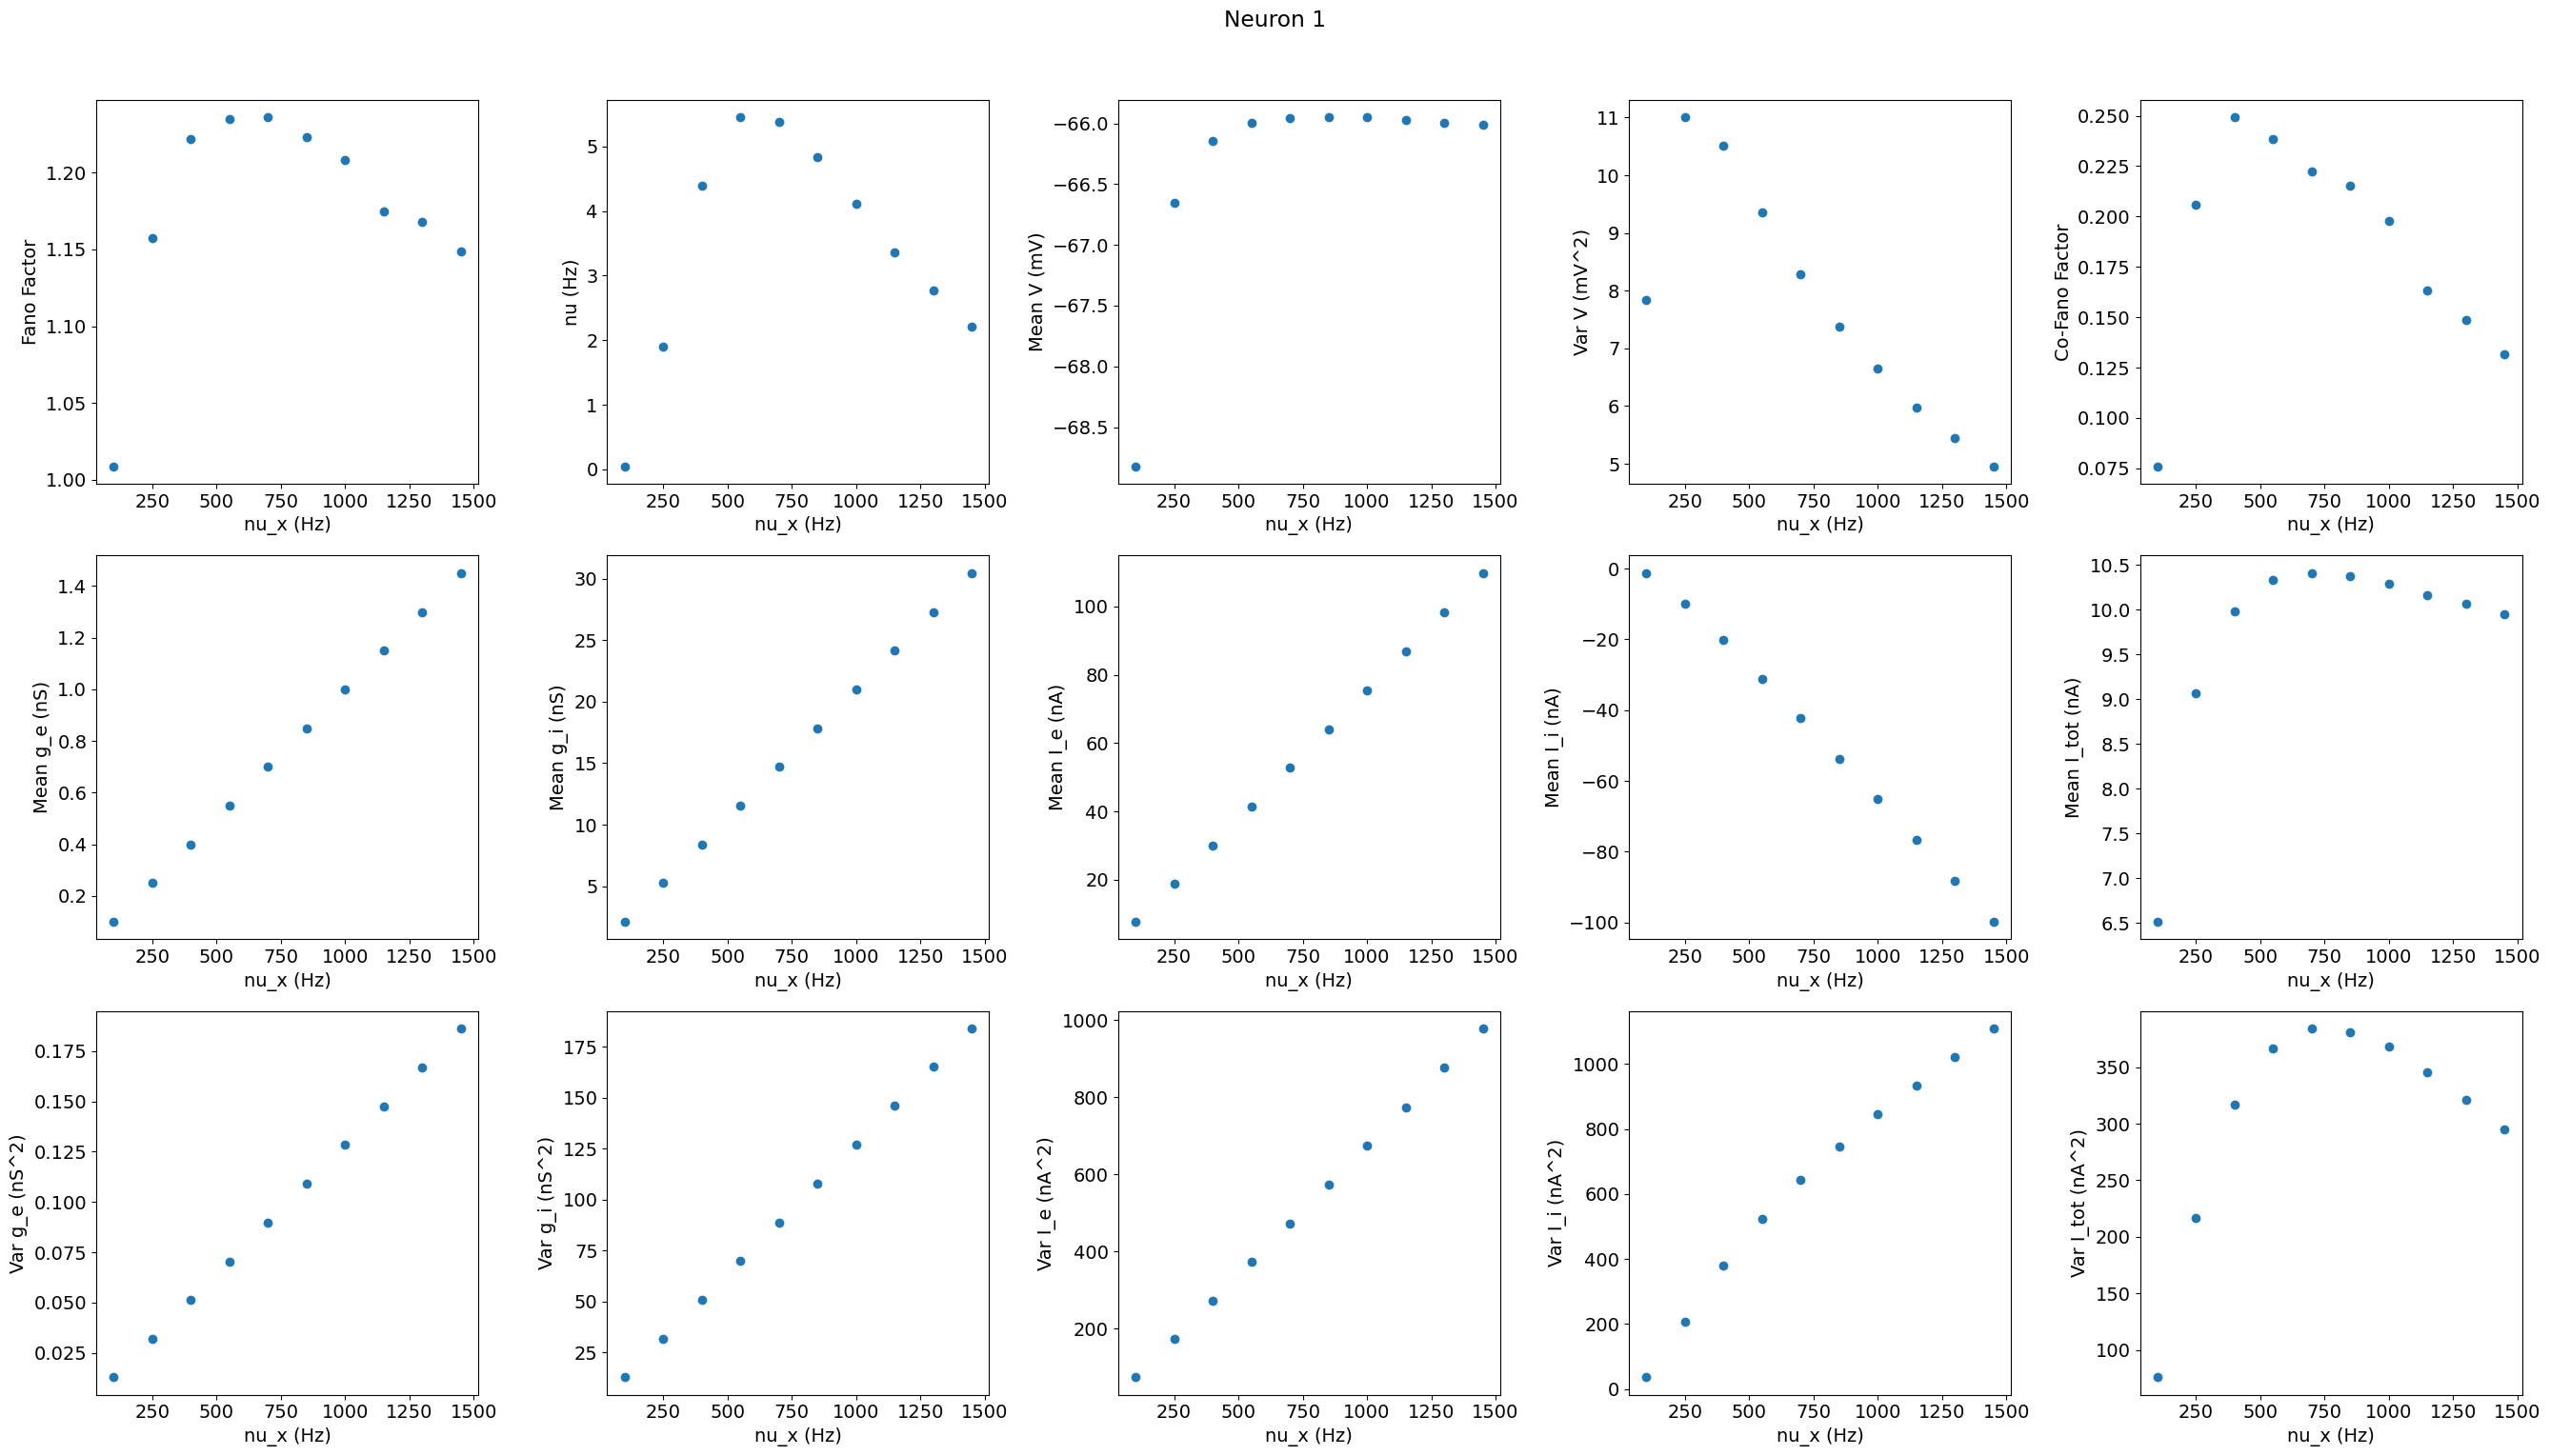

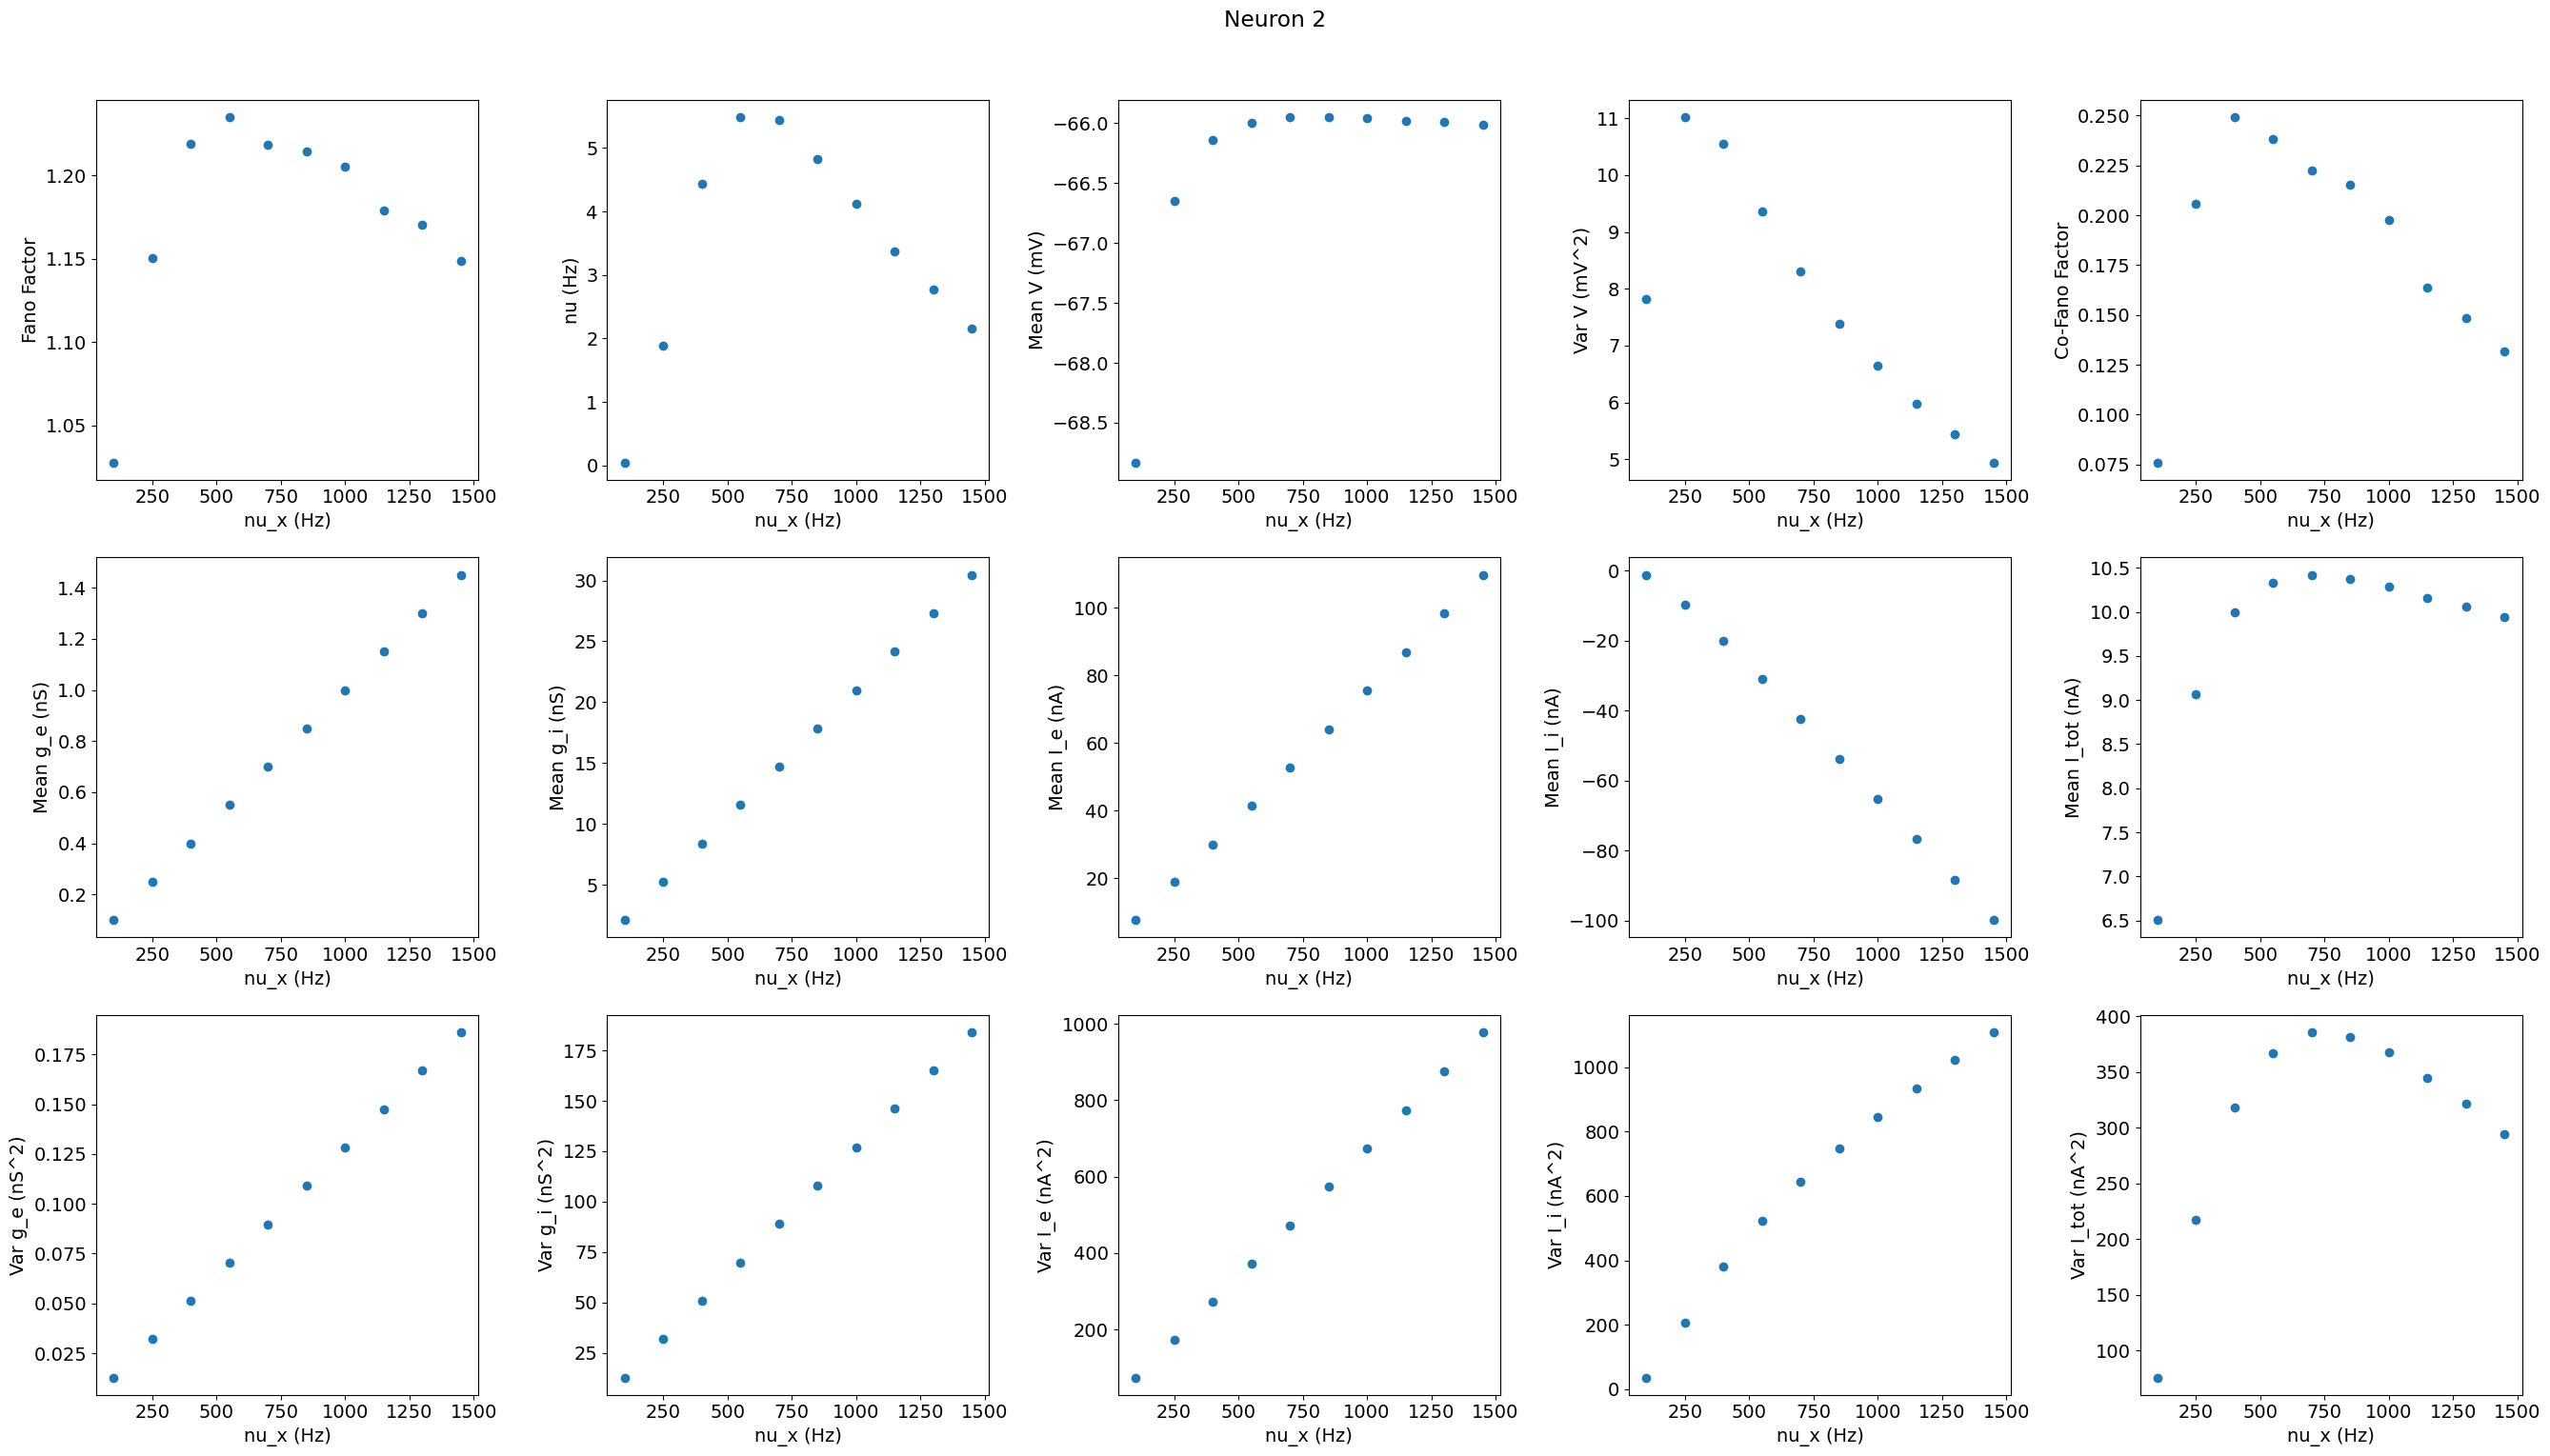

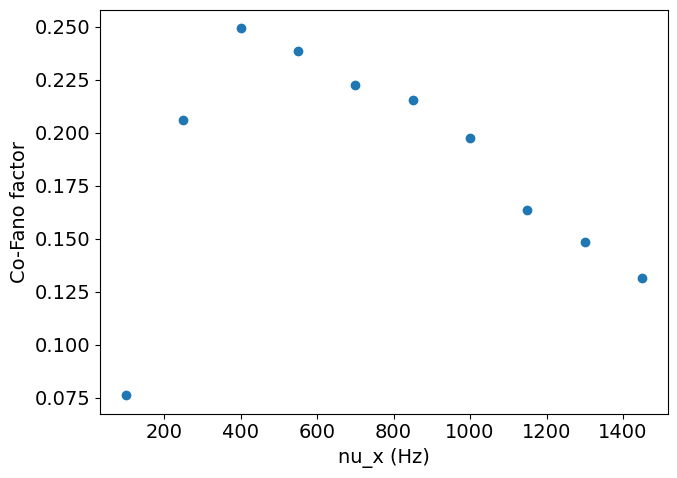

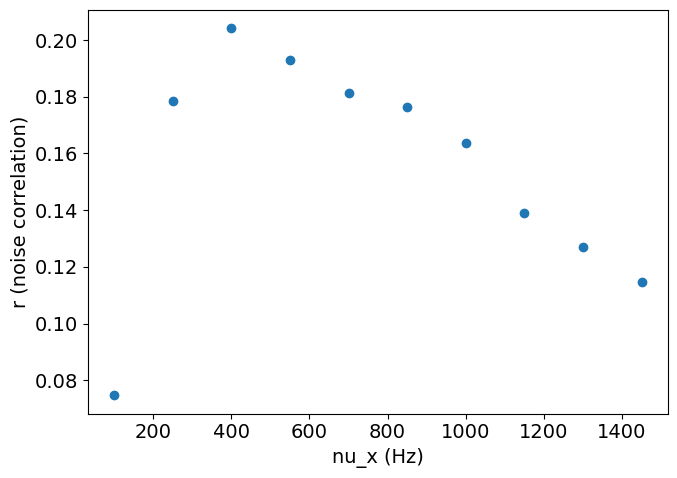

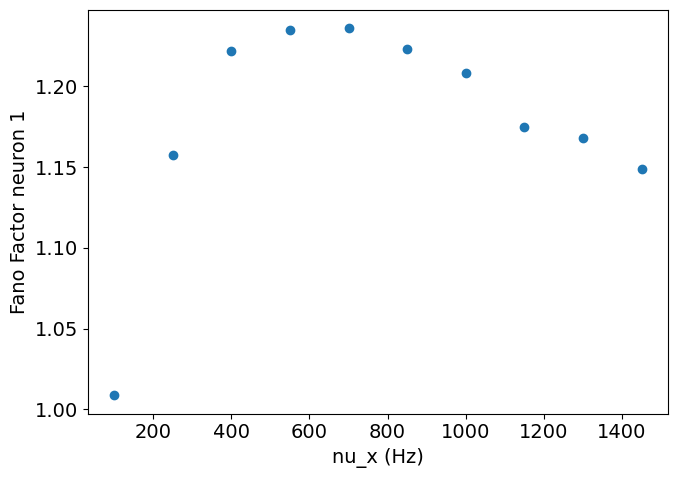

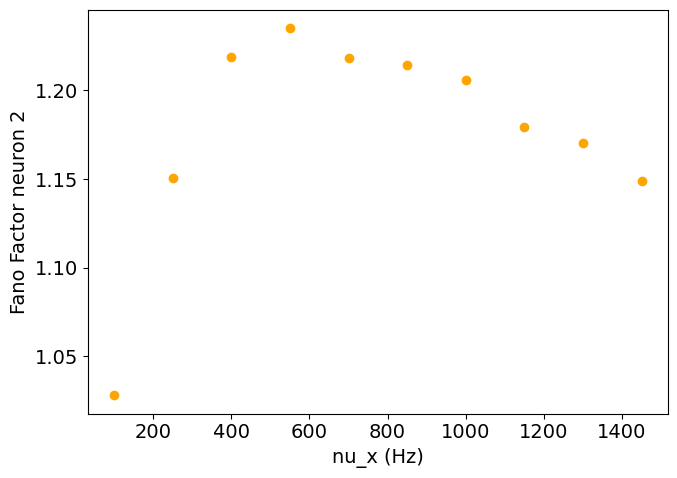

In [8]:
import json


trials = collect_data("../../outputs/conductance/double_lif/nu_x_1/20251016-004114-dZgtdphQ")


plt.rcParams.update({'font.size': 14})

keys = [
    "fano_factor","nu","mean_V","var_V",
    "mean_g_e","mean_g_i","mean_I_e","mean_I_i","mean_I_tot",
    "var_g_e","var_g_i","var_I_e","var_I_i","var_I_tot",
]

N_CELLS = 2

dfs = []
for i in range(N_CELLS):
    rows = []
    for params, results in trials:
        row = {"nu_x": float(params["nu_x"])}
        for k in keys:
            v = results[k]
            if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                row[k] = float(v)
            elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == N_CELLS:
                row[k] = float(v[i])
            # ignore everything else (e.g., 2D buffers or mismatched shapes)
        rows.append(row)
    dfs.append(pd.DataFrame(rows))

df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for _, r in trials]}
)

def plot_summary(df, neuron_idx, outname):
    fig, axs = plt.subplots(3, 5, figsize=(27, 15))
    fig.suptitle(f"Neuron {neuron_idx+1}", y=1.02)

    axs[0,0].scatter(df["nu_x"], df["fano_factor"]); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
    axs[0,1].scatter(df["nu_x"], df["nu"]);          axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
    axs[0,2].scatter(df["nu_x"], df["mean_V"]);      axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
    axs[0,3].scatter(df["nu_x"], df["var_V"]);       axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
    # do co-fano factor both
    axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"]); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

    axs[1,0].scatter(df["nu_x"], df["mean_g_e"]);    axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
    axs[1,1].scatter(df["nu_x"], df["mean_g_i"]);    axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
    axs[1,2].scatter(df["nu_x"], df["mean_I_e"]);    axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
    axs[1,3].scatter(df["nu_x"], df["mean_I_i"]);    axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
    axs[1,4].scatter(df["nu_x"], df["mean_I_tot"]);  axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")

    axs[2,0].scatter(df["nu_x"], df["var_g_e"]);     axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
    axs[2,1].scatter(df["nu_x"], df["var_g_i"]);     axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
    axs[2,2].scatter(df["nu_x"], df["var_I_e"]);     axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
    axs[2,3].scatter(df["nu_x"], df["var_I_i"]);     axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
    axs[2,4].scatter(df["nu_x"], df["var_I_tot"]);   axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")

    plt.tight_layout(); plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()

for i, df in enumerate(dfs):
    plot_summary(df, i, f"detailed_summary_neuron{i+1}.png")

plt.figure(figsize=(7,5))
plt.scatter(df_co["nu_x"], df_co["co_fano_factor"])
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.tight_layout(); plt.savefig("co_fano_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

# noise correlation vs nu_x for various c
plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
plt.scatter(df_co["nu_x"], df_co["r"])
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.tight_layout(); plt.savefig("r_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

# plot the two fano factors vs nu_x in two new plots
# neuron 1
plt.figure(figsize=(7,5))
plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], label="Neuron 1")
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano Factor neuron 1")
plt.tight_layout(); plt.savefig("fano_neuron1_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

# neuron 2
plt.figure(figsize=(7,5))
plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], label="Neuron 2", color='orange')
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano Factor neuron 2")
plt.tight_layout(); plt.savefig("fano_neuron2_vs_nu_x.png", dpi=300, bbox_inches="tight"); plt.show()

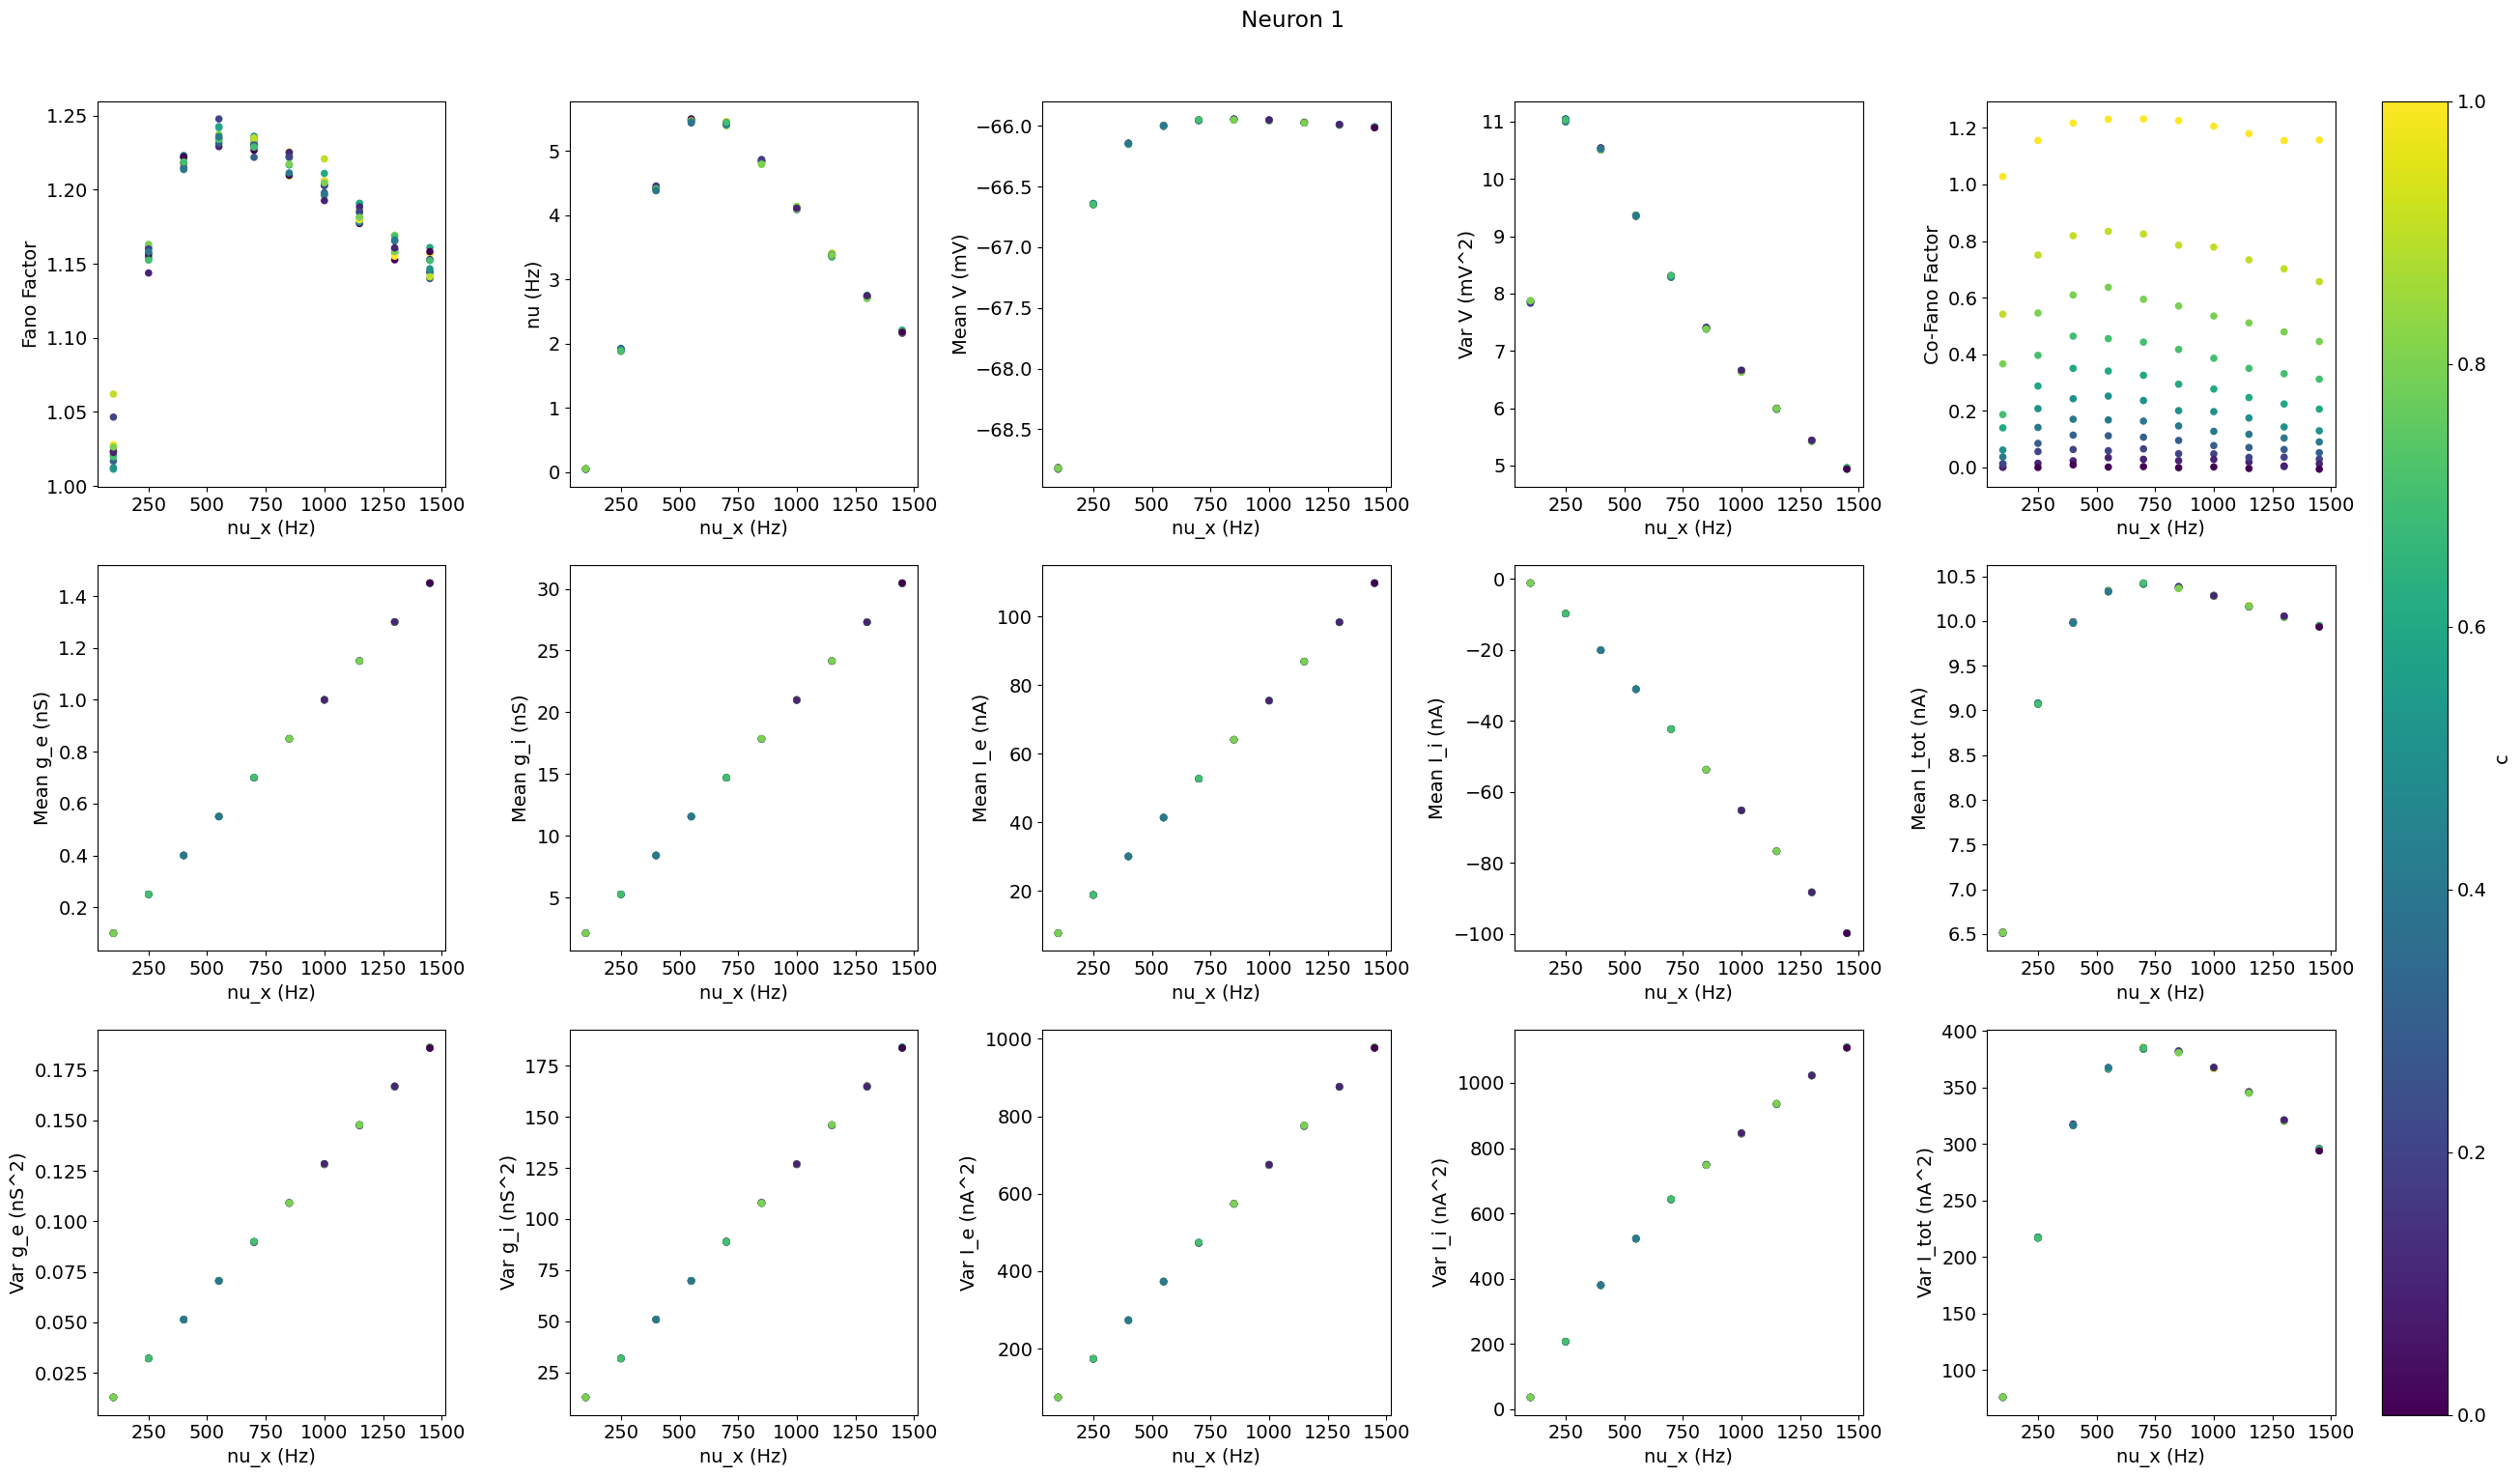

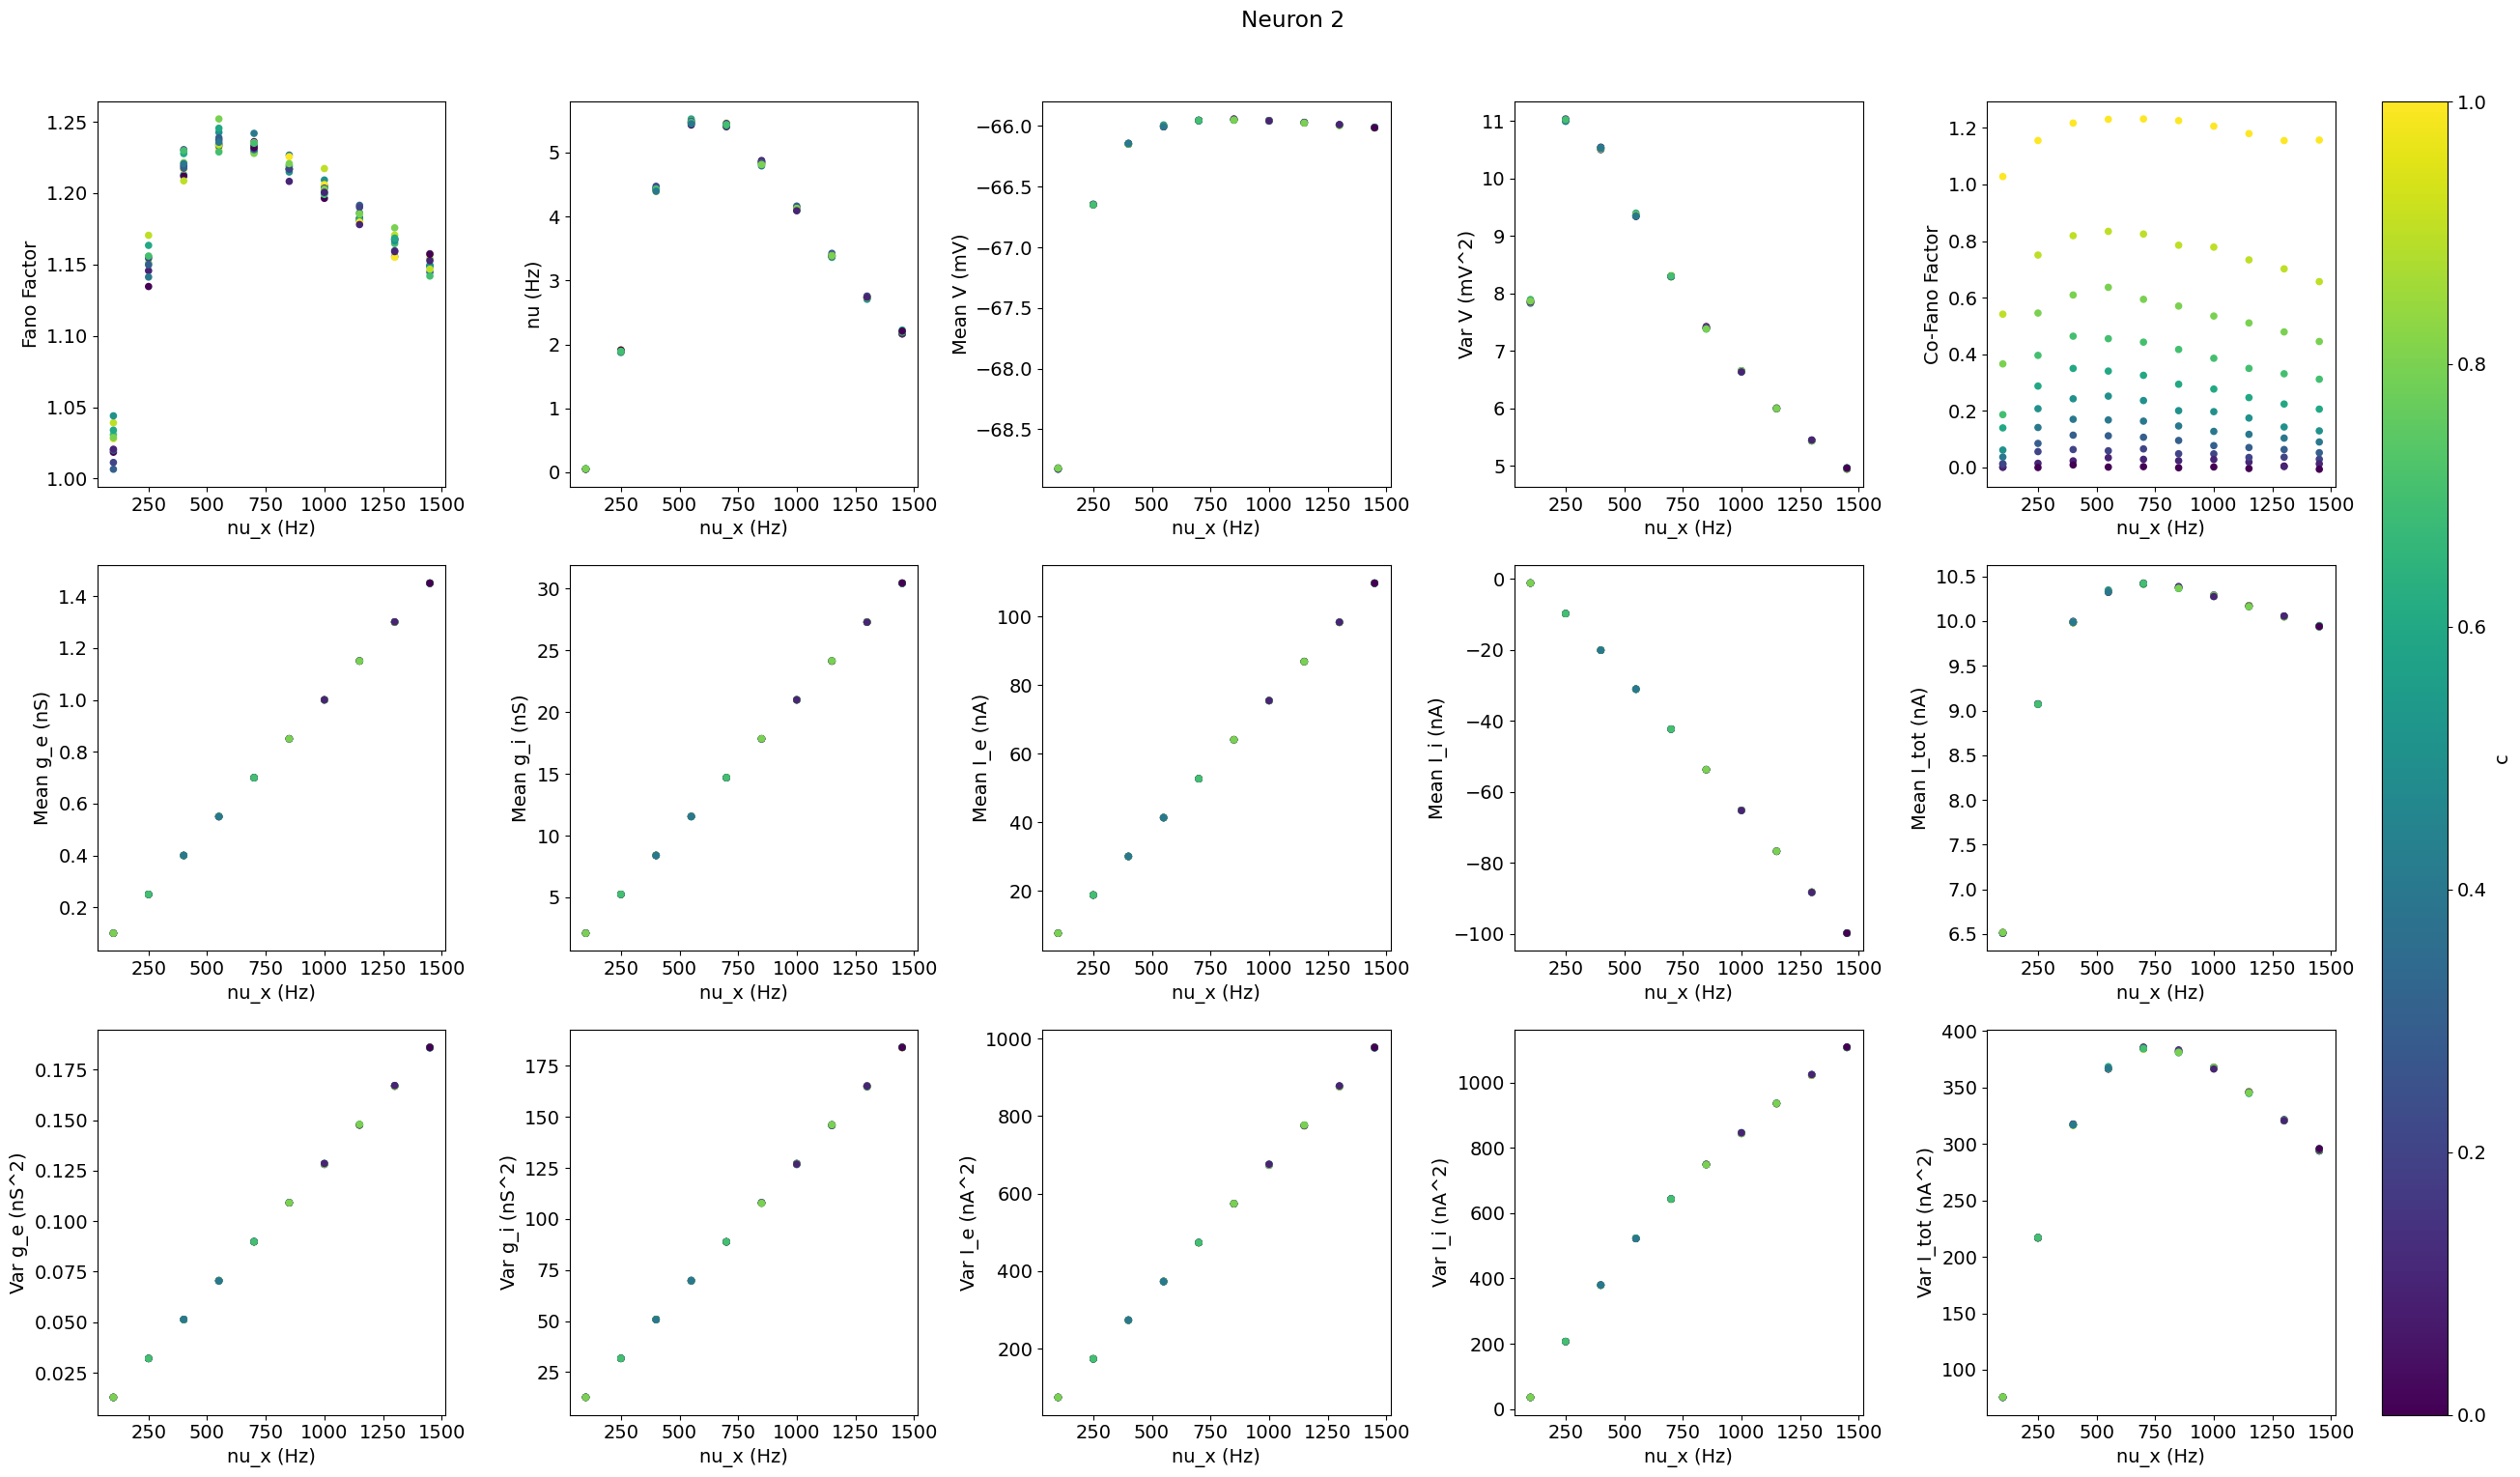

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trials = collect_data("../../outputs/conductance/double_lif/nu_x_c/20251016-011349-P6DLbbnK")
plt.rcParams.update({'font.size': 14})

keys = [
    "fano_factor","nu","mean_V","var_V",
    "mean_g_e","mean_g_i","mean_I_e","mean_I_i","mean_I_tot",
    "var_g_e","var_g_i","var_I_e","var_I_i","var_I_tot",
]

N_CELLS = 2

dfs = []
for i in range(N_CELLS):
    rows = []
    for params, results in trials:
        row = {"nu_x": float(params["nu_x"]), "c": float(params["c"])}
        for k in keys:
            v = results[k]
            if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                row[k] = float(v)
            elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == N_CELLS:
                row[k] = float(v[i])
        rows.append(row)
    dfs.append(pd.DataFrame(rows))

df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials],
     "c":    [float(p["c"])    for p, _ in trials],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for _, r in trials]}
)



def plot_summary(df, neuron_idx, outname):
    fig, axs = plt.subplots(3, 5, figsize=(27, 15))
    fig.suptitle(f"Neuron {neuron_idx+1}", y=1.02)
    opts = dict(c=df["c"], cmap="viridis", vmin=0, vmax=1, s=20)

    axs[0,0].scatter(df["nu_x"], df["fano_factor"], **opts); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
    axs[0,1].scatter(df["nu_x"], df["nu"],          **opts); axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
    axs[0,2].scatter(df["nu_x"], df["mean_V"],      **opts); axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
    axs[0,3].scatter(df["nu_x"], df["var_V"],       **opts); axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
    axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"], **opts); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

    axs[1,0].scatter(df["nu_x"], df["mean_g_e"],    **opts); axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
    axs[1,1].scatter(df["nu_x"], df["mean_g_i"],    **opts); axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
    axs[1,2].scatter(df["nu_x"], df["mean_I_e"],    **opts); axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
    axs[1,3].scatter(df["nu_x"], df["mean_I_i"],    **opts); axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
    axs[1,4].scatter(df["nu_x"], df["mean_I_tot"],  **opts); axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")

    axs[2,0].scatter(df["nu_x"], df["var_g_e"],     **opts); axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
    axs[2,1].scatter(df["nu_x"], df["var_g_i"],     **opts); axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
    axs[2,2].scatter(df["nu_x"], df["var_I_e"],     **opts); axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
    axs[2,3].scatter(df["nu_x"], df["var_I_i"],     **opts); axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
    axs[2,4].scatter(df["nu_x"], df["var_I_tot"],   **opts); axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")

    sm = plt.cm.ScalarMappable(cmap="viridis"); sm.set_clim(0,1)
    plt.tight_layout(rect=[0, 0, 0.96, 1])  # leave right margin
    fig.colorbar(sm, ax=axs.ravel().tolist(), location="right",
                fraction=0.03, pad=0.02, label="c")
    plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()

for i, df in enumerate(dfs):
    plot_summary(df, i, f"detailed_summary_neuron{i+1}_by_c.png")


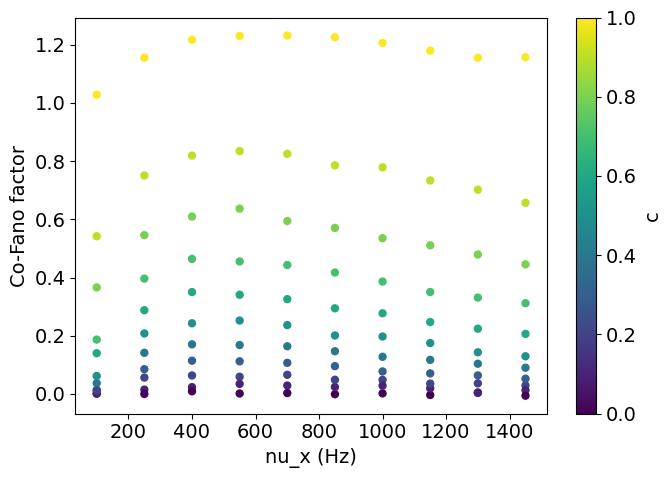

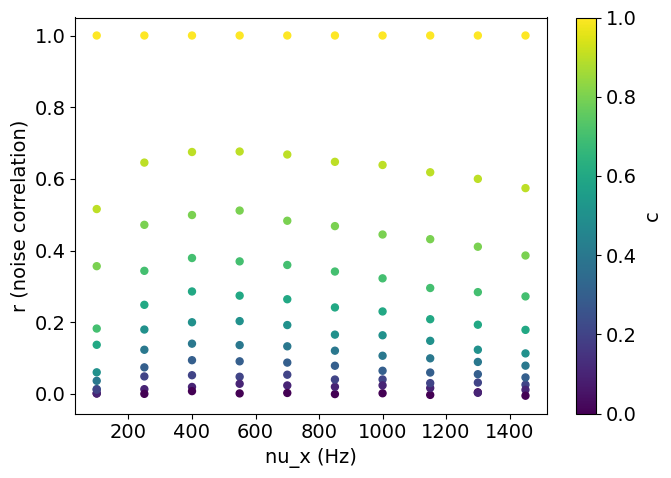

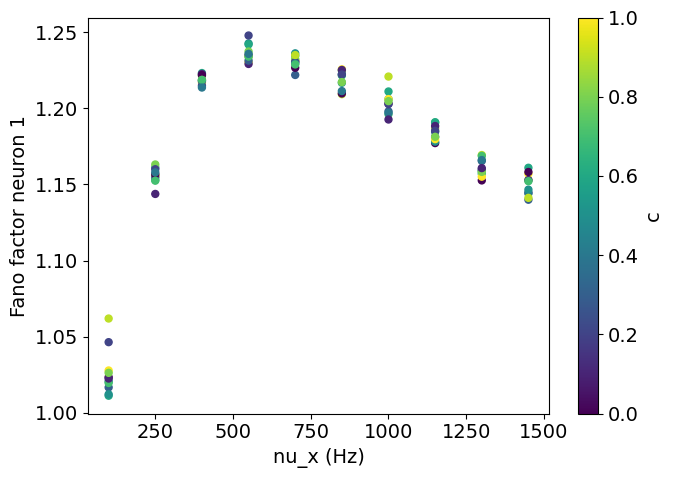

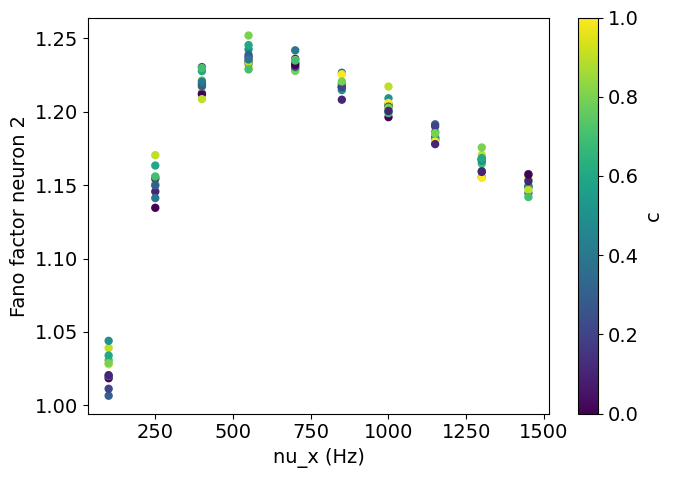

In [6]:
plt.figure(figsize=(7,5))
sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("co_fano_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

# define r = co_fano_factor / sqrt(fano_factor1 * fano_factor2
# now plot this against nu_x for various c

plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("r_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

# also plot the two fano factors in two separate plots versus nu_x
plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], c=dfs[0]["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 1")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("fano1_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], c=dfs[1]["c"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 2")
plt.colorbar(sc, label="c")
plt.tight_layout(); plt.savefig("fano2_vs_nu_x_by_c.png", dpi=300, bbox_inches="tight"); plt.show()

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trials = collect_data("../../outputs/conductance/double_lif/nu_x_c_e_c_i/20251016-110604-Ov4lxrFn")
plt.rcParams.update({'font.size': 14})

keys = [
    "fano_factor","nu","mean_V","var_V",
    "mean_g_e","mean_g_i","mean_I_e","mean_I_i","mean_I_tot",
    "var_g_e","var_g_i","var_I_e","var_I_i","var_I_tot",
]

# same as before, but now we have two labels: c_e and c_i.
# we will still produce the value versus nu_x plots, but now we can choose a fixed c_e and vary c_i, or vice versa.

N_CELLS = 2
dfs_all = []
for i in range(N_CELLS):
    rows = []
    for params, results in trials:
        row = {"nu_x": float(params["nu_x"]),
               "c_e": float(params["c_e"]),
               "c_i": float(params["c_i"])}
        for k in keys:
            v = results[k]
            if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                row[k] = float(v)
            elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == N_CELLS:
                row[k] = float(v[i])
        rows.append(row)
    dfs_all.append(pd.DataFrame(rows))
    
df_co_all = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials],
     "c_e":  [float(p["c_e"])   for p, _ in trials],
     "c_i":  [float(p["c_i"])   for p, _ in trials],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for _, r in trials]}
)

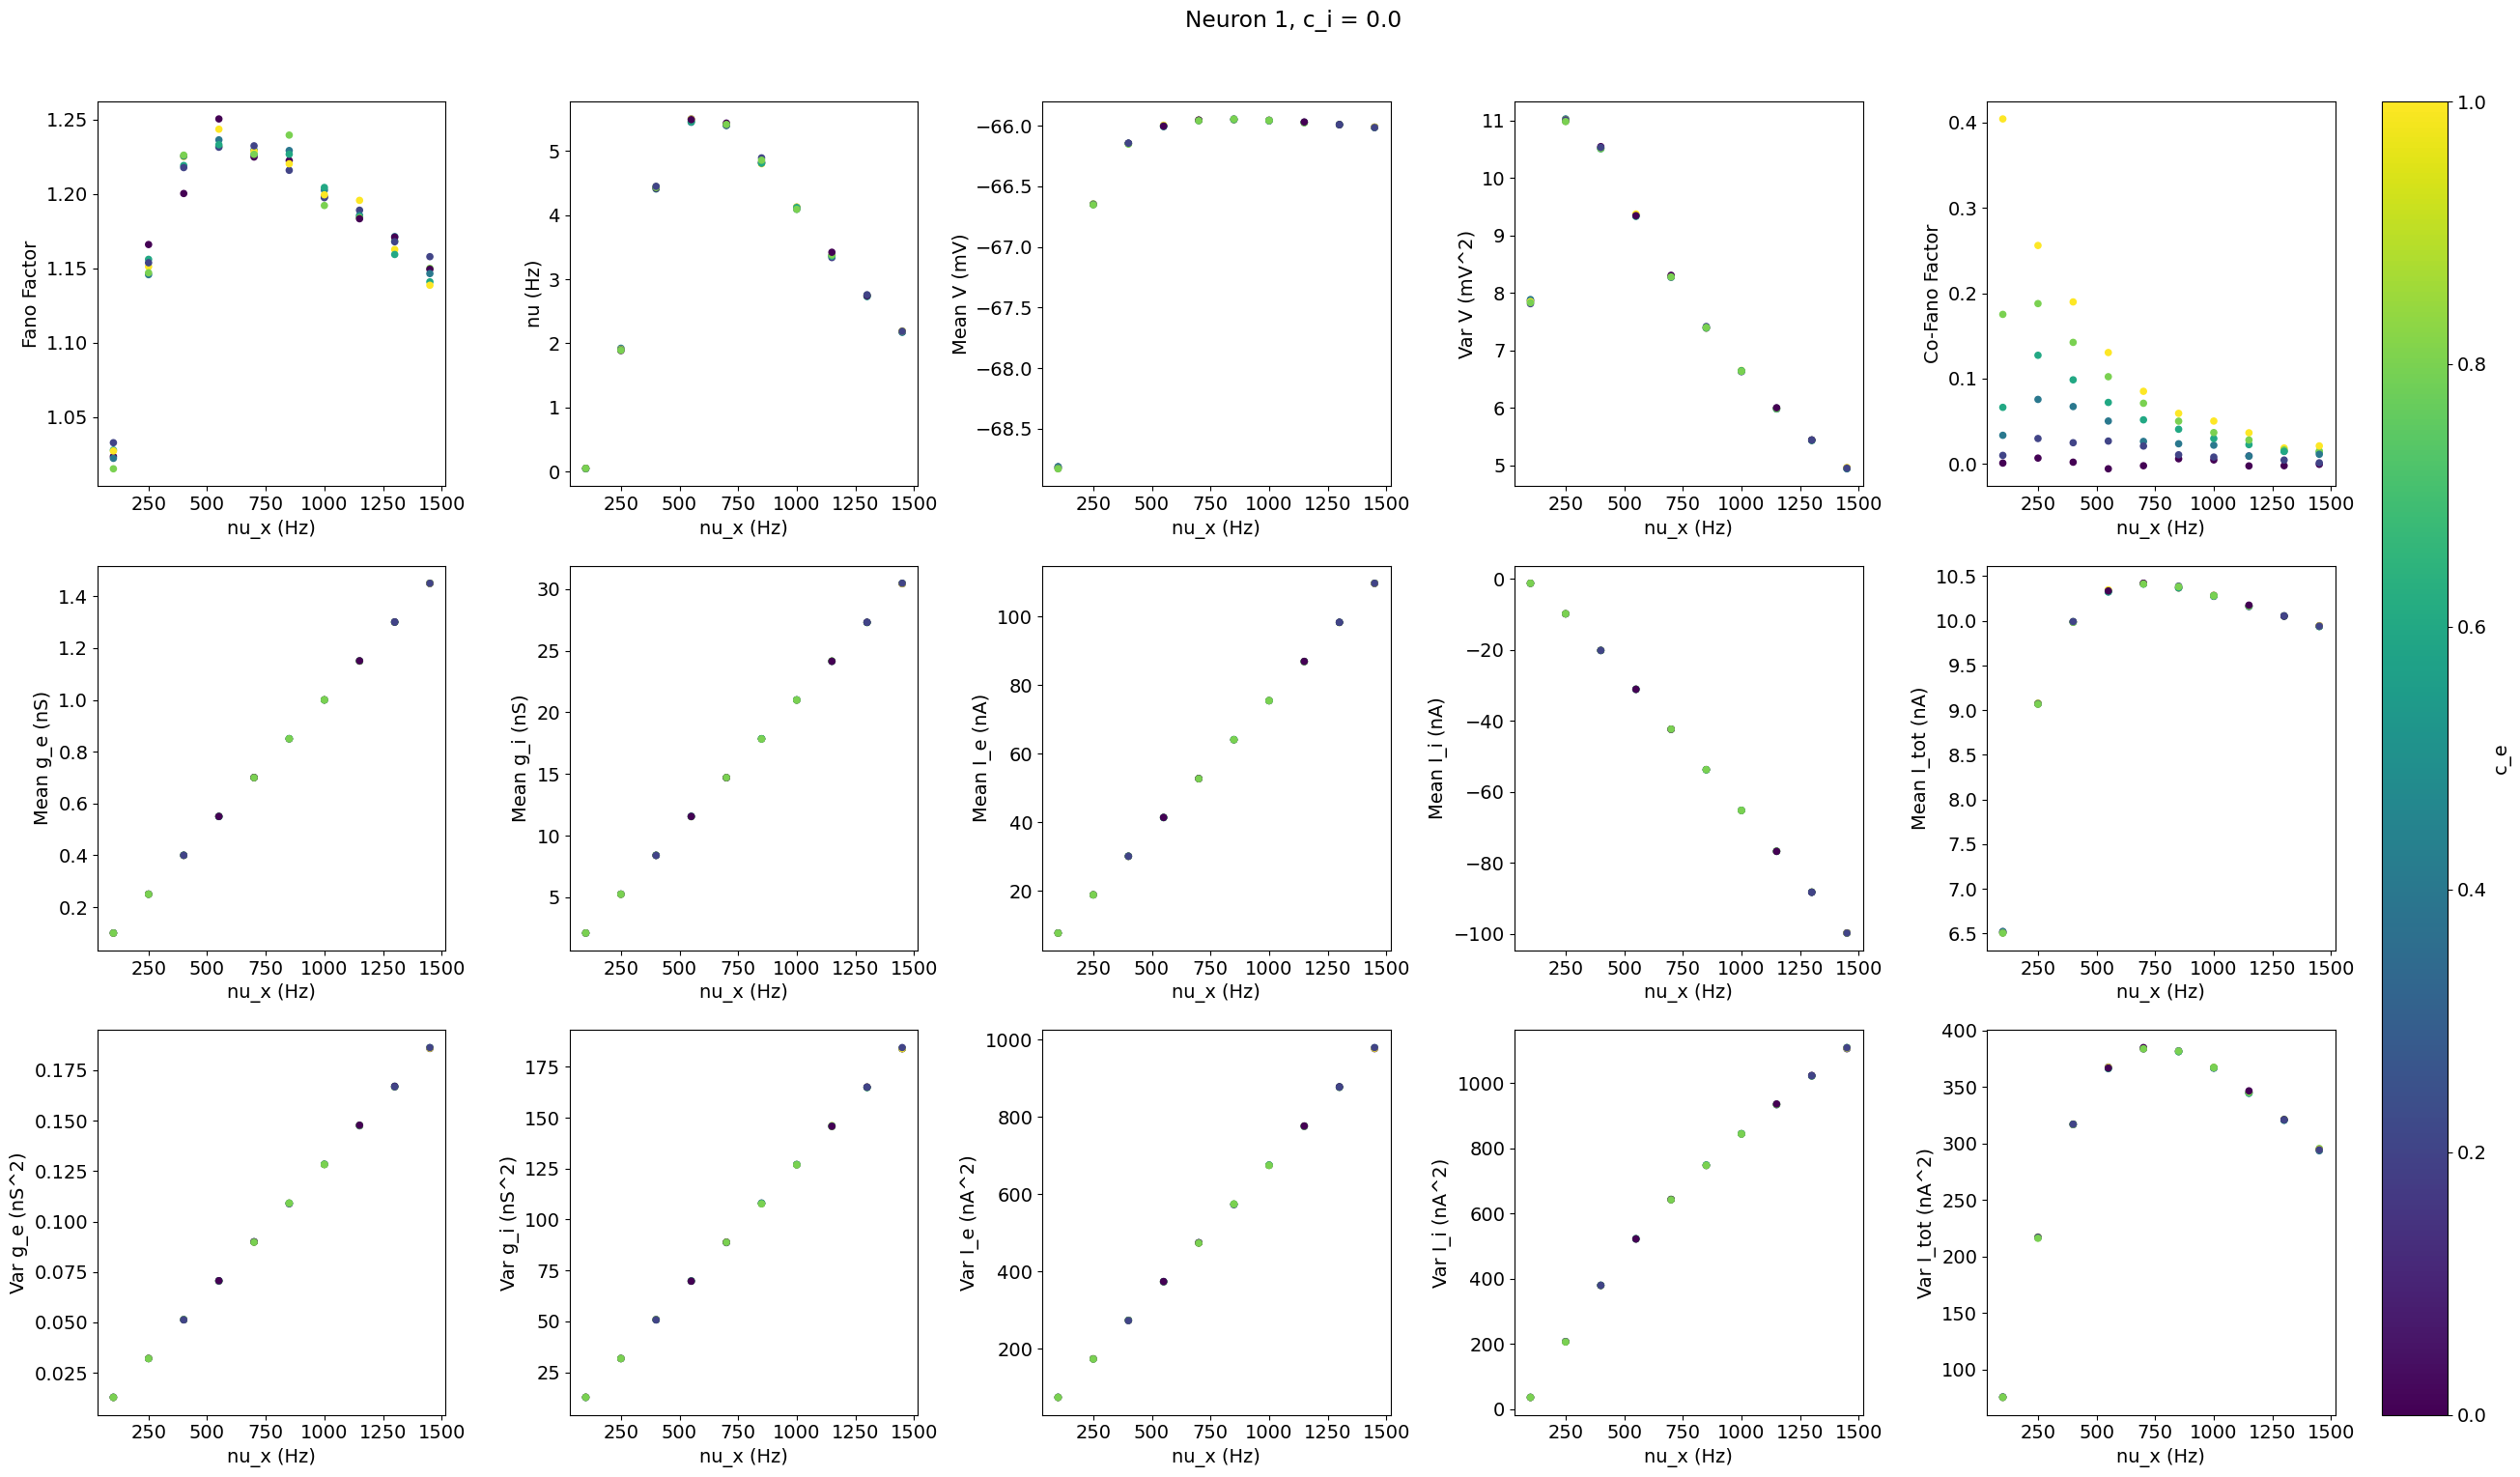

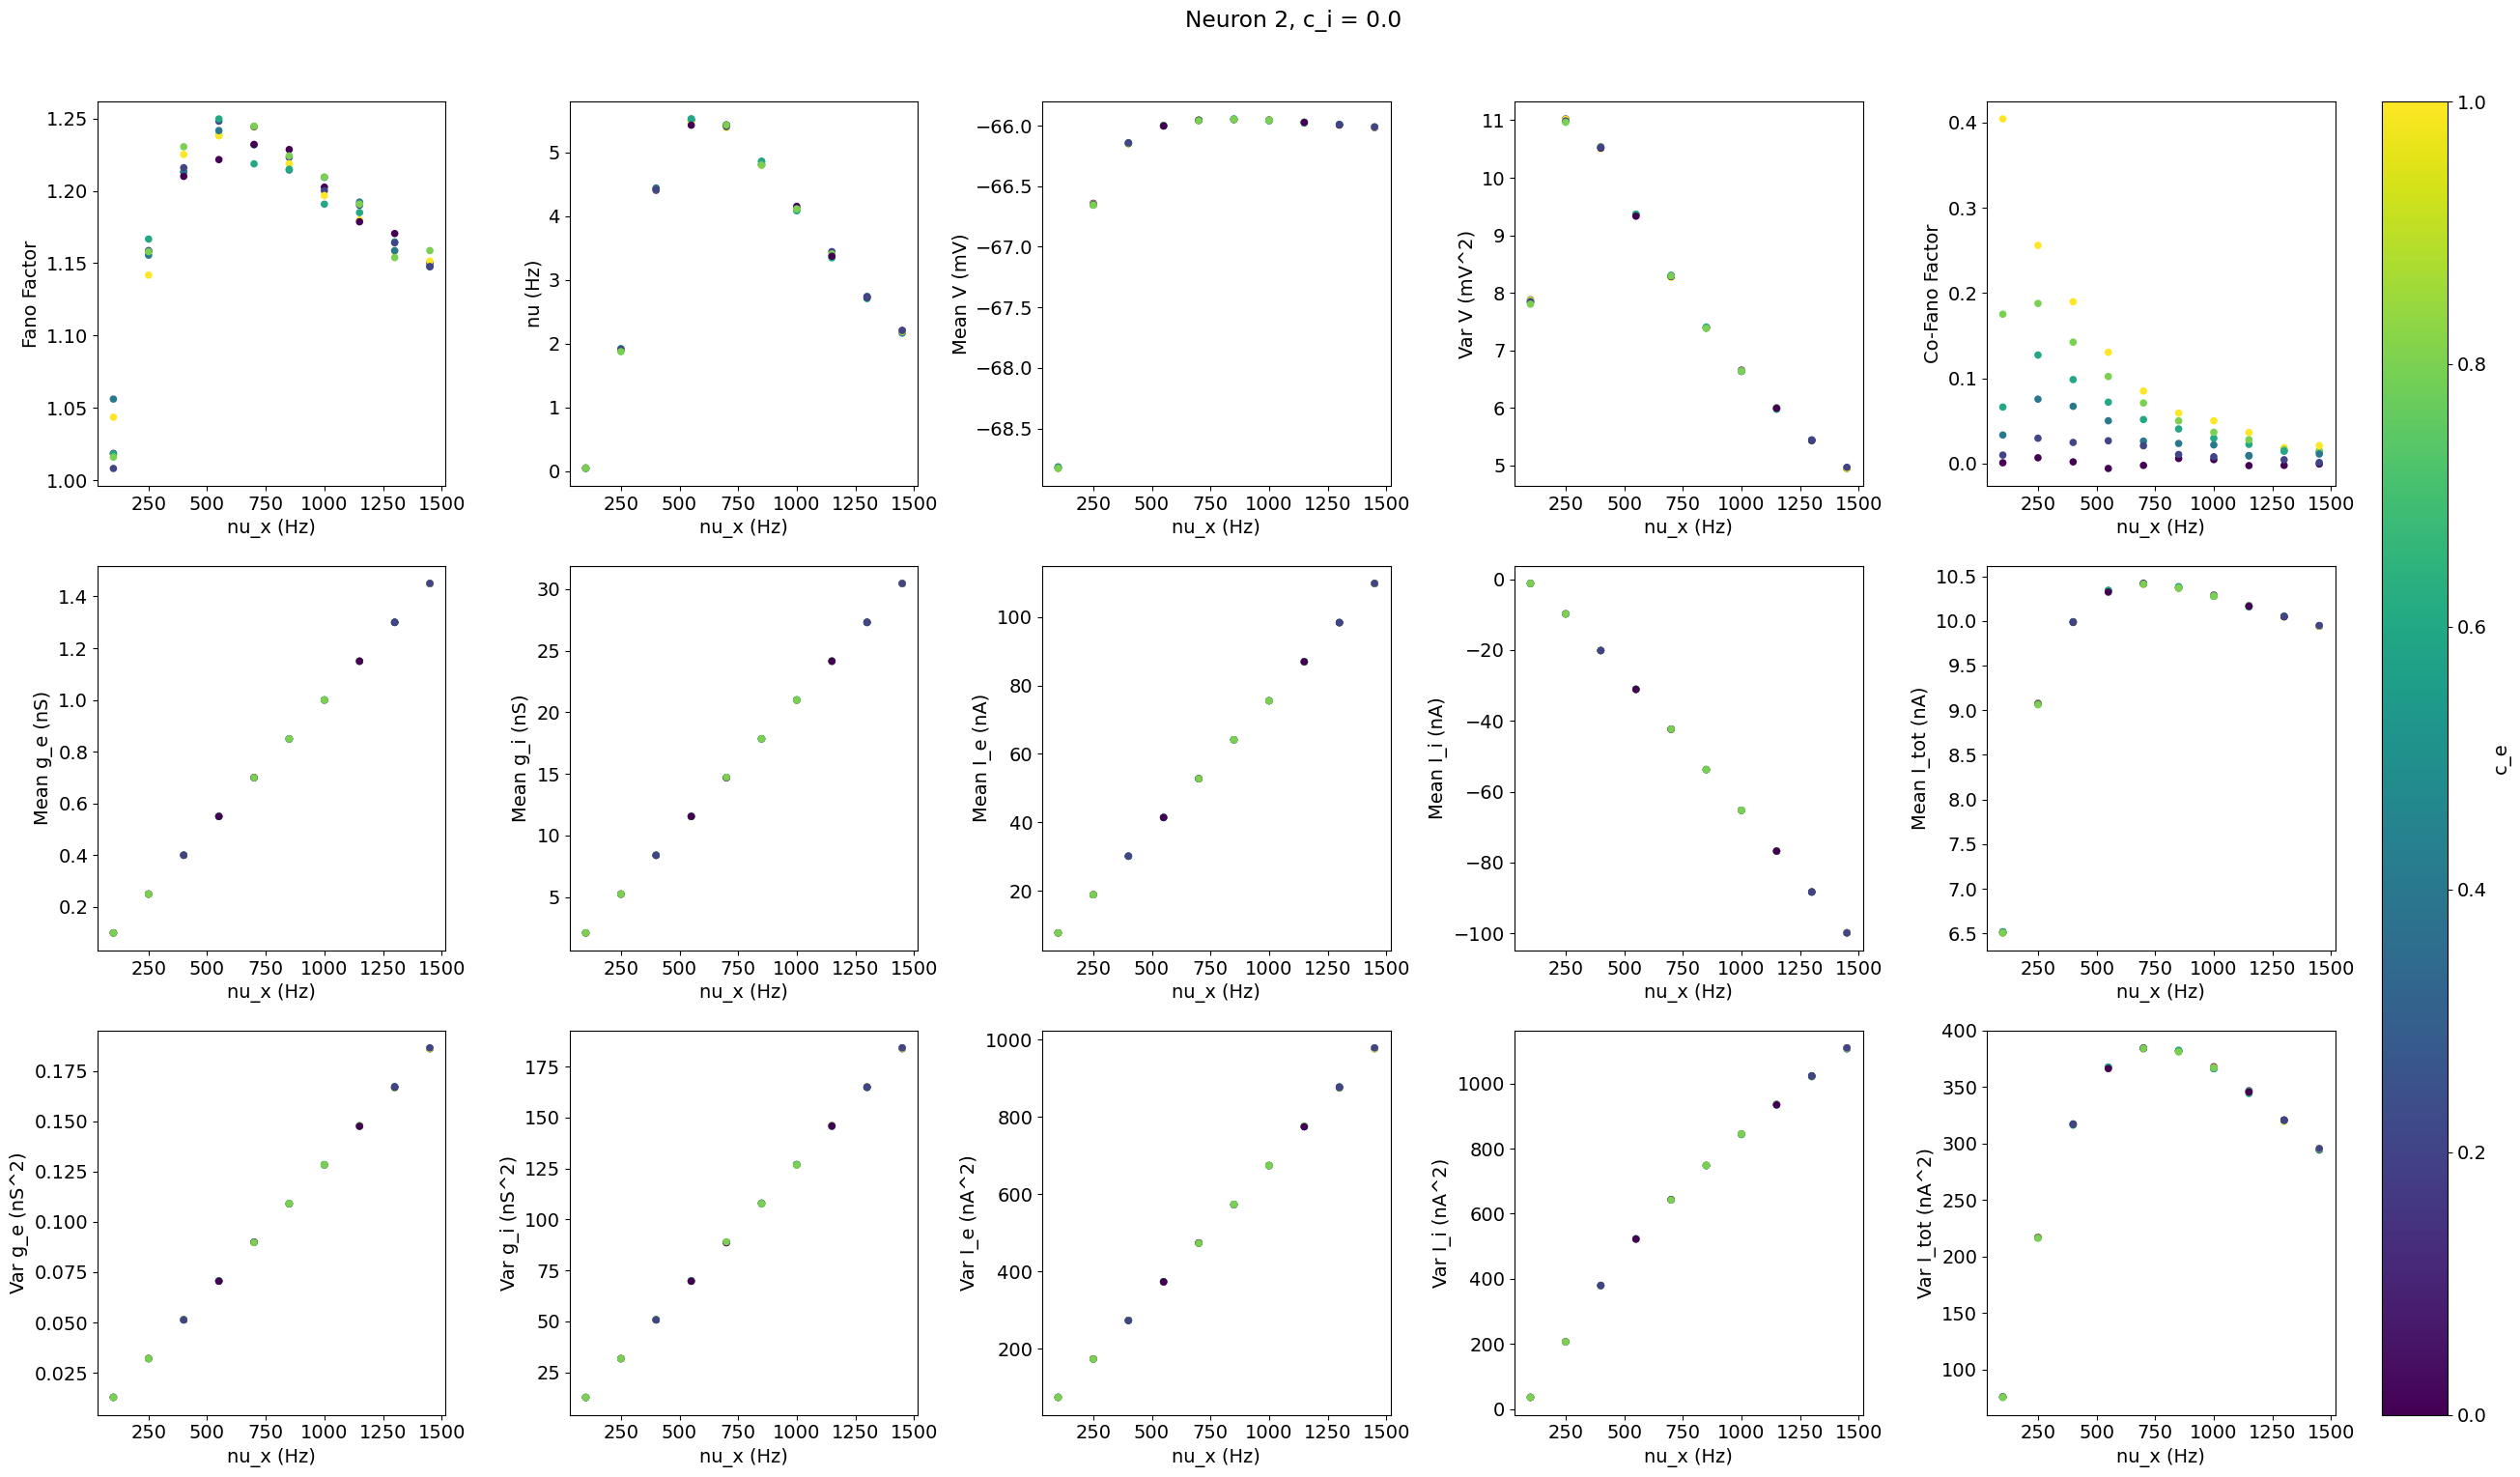

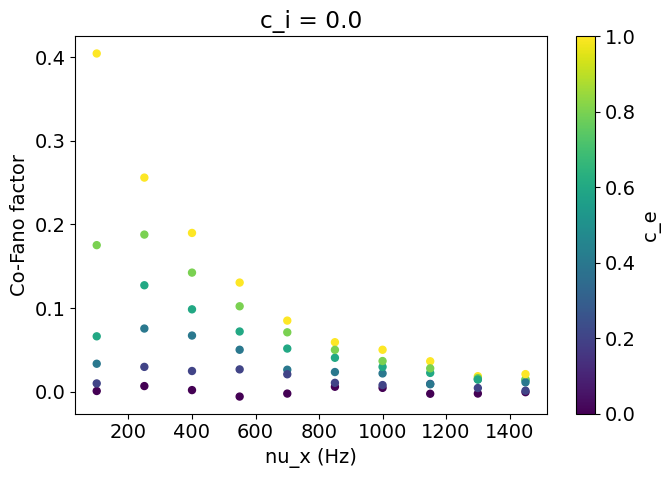

/var/folders/mb/f1_g1g0n1s13vfylsby2v1bm0000gn/T/ipykernel_88194/2865504902.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])


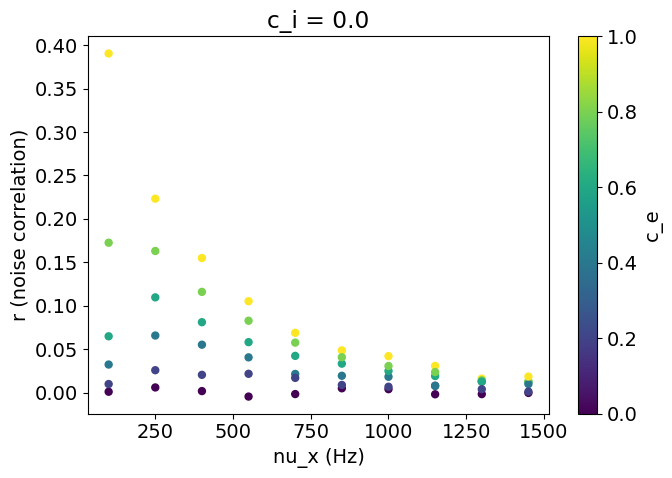

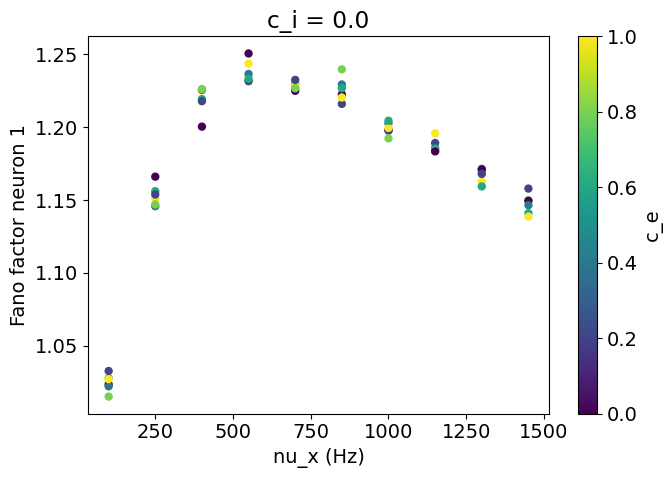

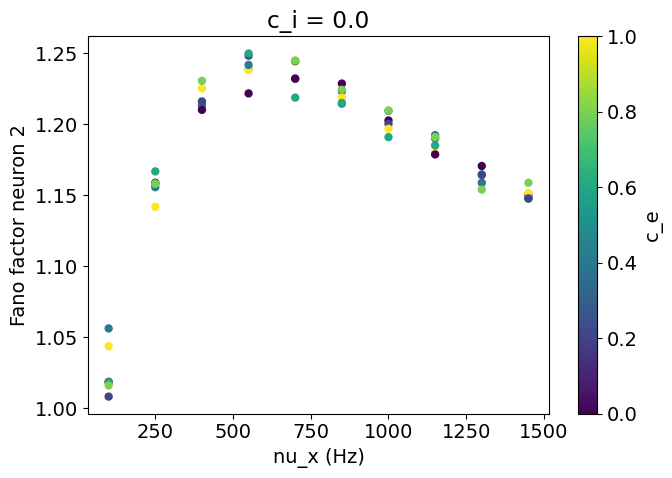

In [34]:
for ci_fixed in [0.0]:

    dfs = []
    for i in range(N_CELLS):
        df = dfs_all[i][dfs_all[i]["c_i"] == ci_fixed]
        dfs.append(df)
        
    df_co = df_co_all[df_co_all["c_i"] == ci_fixed]

    def plot_summary(df, neuron_idx, outname):
        fig, axs = plt.subplots(3, 5, figsize=(27, 15))
        fig.suptitle(f"Neuron {neuron_idx+1}, c_i = {ci_fixed}", y=1.02)
        opts = dict(c=df["c_e"], cmap="viridis", vmin=0, vmax=1, s=20)

        axs[0,0].scatter(df["nu_x"], df["fano_factor"], **opts); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
        axs[0,1].scatter(df["nu_x"], df["nu"],          **opts); axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
        axs[0,2].scatter(df["nu_x"], df["mean_V"],      **opts); axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
        axs[0,3].scatter(df["nu_x"], df["var_V"],       **opts); axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
        axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"], **opts); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

        axs[1,0].scatter(df["nu_x"], df["mean_g_e"],    **opts); axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
        axs[1,1].scatter(df["nu_x"], df["mean_g_i"],    **opts); axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
        axs[1,2].scatter(df["nu_x"], df["mean_I_e"],    **opts); axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
        axs[1,3].scatter(df["nu_x"], df["mean_I_i"],    **opts); axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
        axs[1,4].scatter(df["nu_x"], df["mean_I_tot"],  **opts); axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")
        
        axs[2,0].scatter(df["nu_x"], df["var_g_e"],     **opts); axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
        axs[2,1].scatter(df["nu_x"], df["var_g_i"],     **opts); axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
        axs[2,2].scatter(df["nu_x"], df["var_I_e"],     **opts); axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
        axs[2,3].scatter(df["nu_x"], df["var_I_i"],     **opts); axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
        axs[2,4].scatter(df["nu_x"], df["var_I_tot"],   **opts); axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")
        
        sm = plt.cm.ScalarMappable(cmap="viridis"); sm.set_clim(0,1)
        plt.tight_layout(rect=[0, 0, 0.96, 1])  # leave right margin
        fig.colorbar(sm, ax=axs.ravel().tolist(), location="right",
                    fraction=0.03, pad=0.02, label="c_e")
        plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()
        
    for i, df in enumerate(dfs):
        plot_summary(df, i, f"detailed_summary_neuron{i+1}_by_c_e_fixed_c_i={ci_fixed}.png")
        
    plt.figure(figsize=(7,5))
    sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
    plt.colorbar(sc, label="c_e")
    plt.title(f"c_i = {ci_fixed}")
    plt.tight_layout(); plt.savefig(f"co_fano_vs_nu_x_by_c_e_fixed_c_i={ci_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(7,5))
    df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
    sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
    plt.colorbar(sc, label="c_e")
    plt.title(f"c_i = {ci_fixed}")
    plt.tight_layout(); plt.savefig(f"r_vs_nu_x_by_c_e_fixed_c_i={ci_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    # also plot the two fano factors in two separate plots versus nu_x
    plt.figure(figsize=(7,5))
    sc = plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], c=dfs[0]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 1")
    plt.colorbar(sc, label="c_e")
    plt.title(f"c_i = {ci_fixed}")
    plt.tight_layout(); plt.savefig(f"fano1_vs_nu_x_by_c_e_fixed_c_i={ci_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(7,5))
    sc = plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], c=dfs[1]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 2")
    plt.colorbar(sc, label="c_e")
    plt.title(f"c_i = {ci_fixed}")
    plt.tight_layout(); plt.savefig(f"fano2_vs_nu_x_by_c_e_fixed_c_i={ci_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

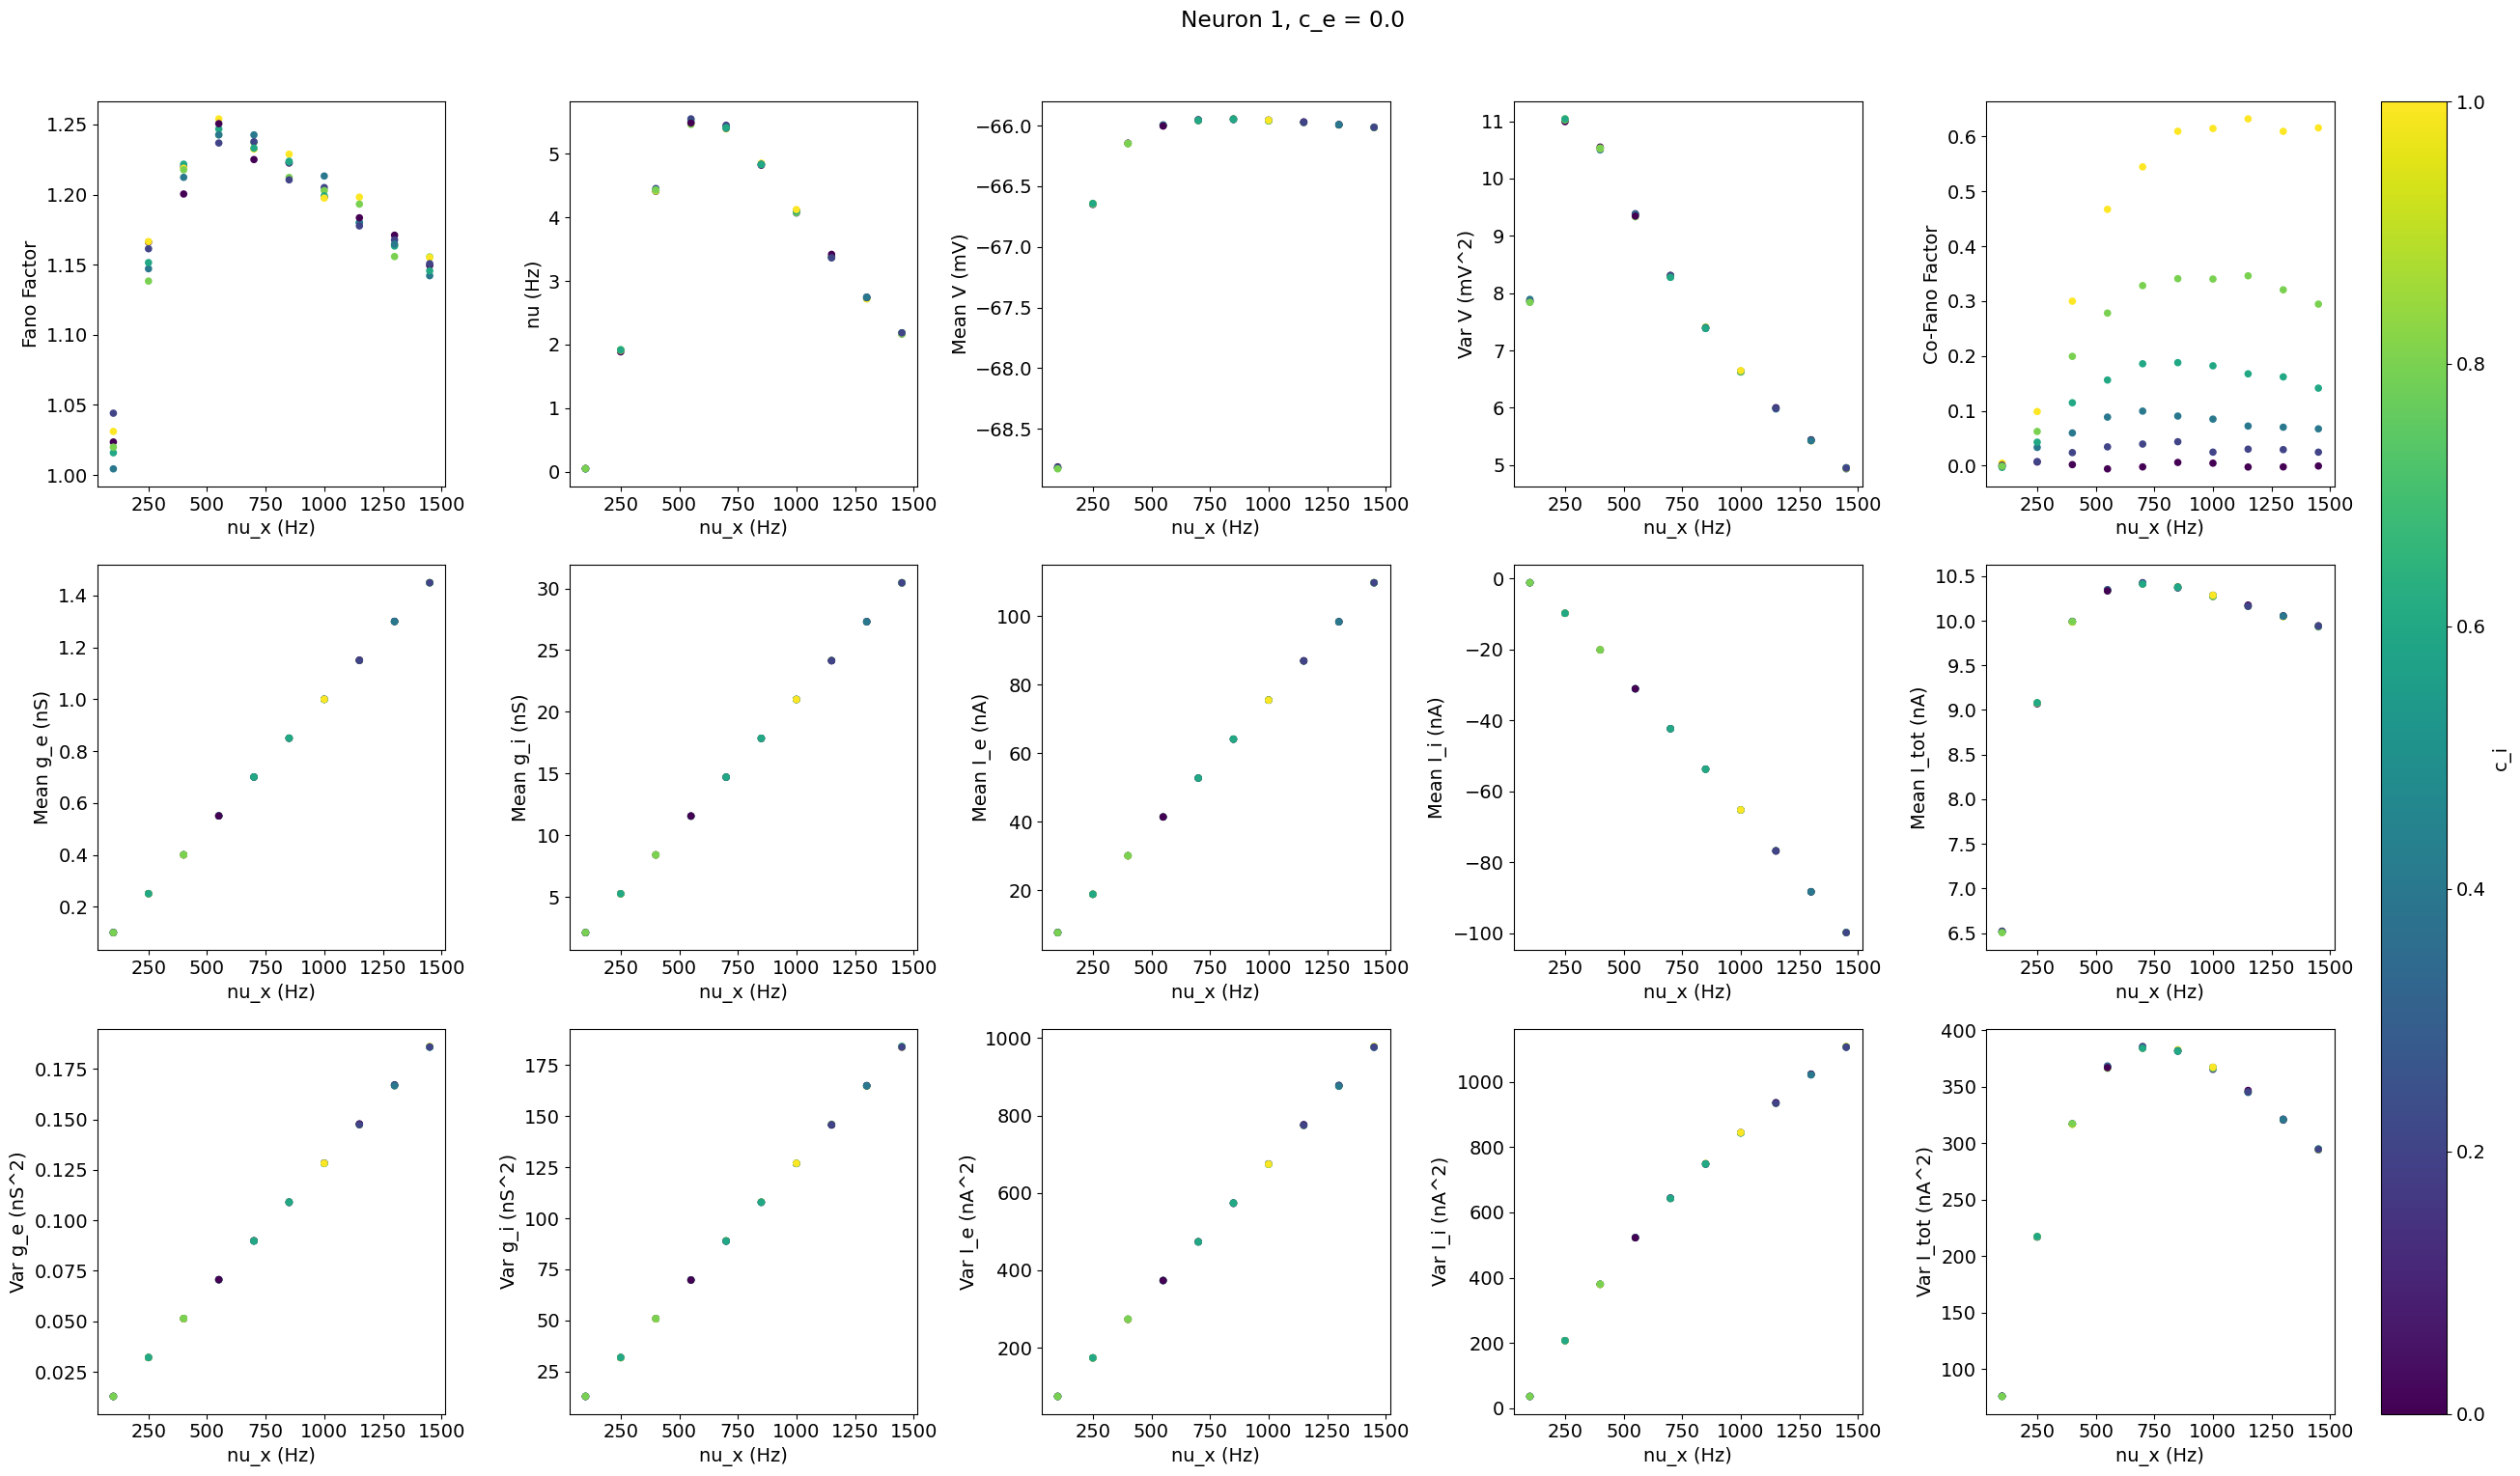

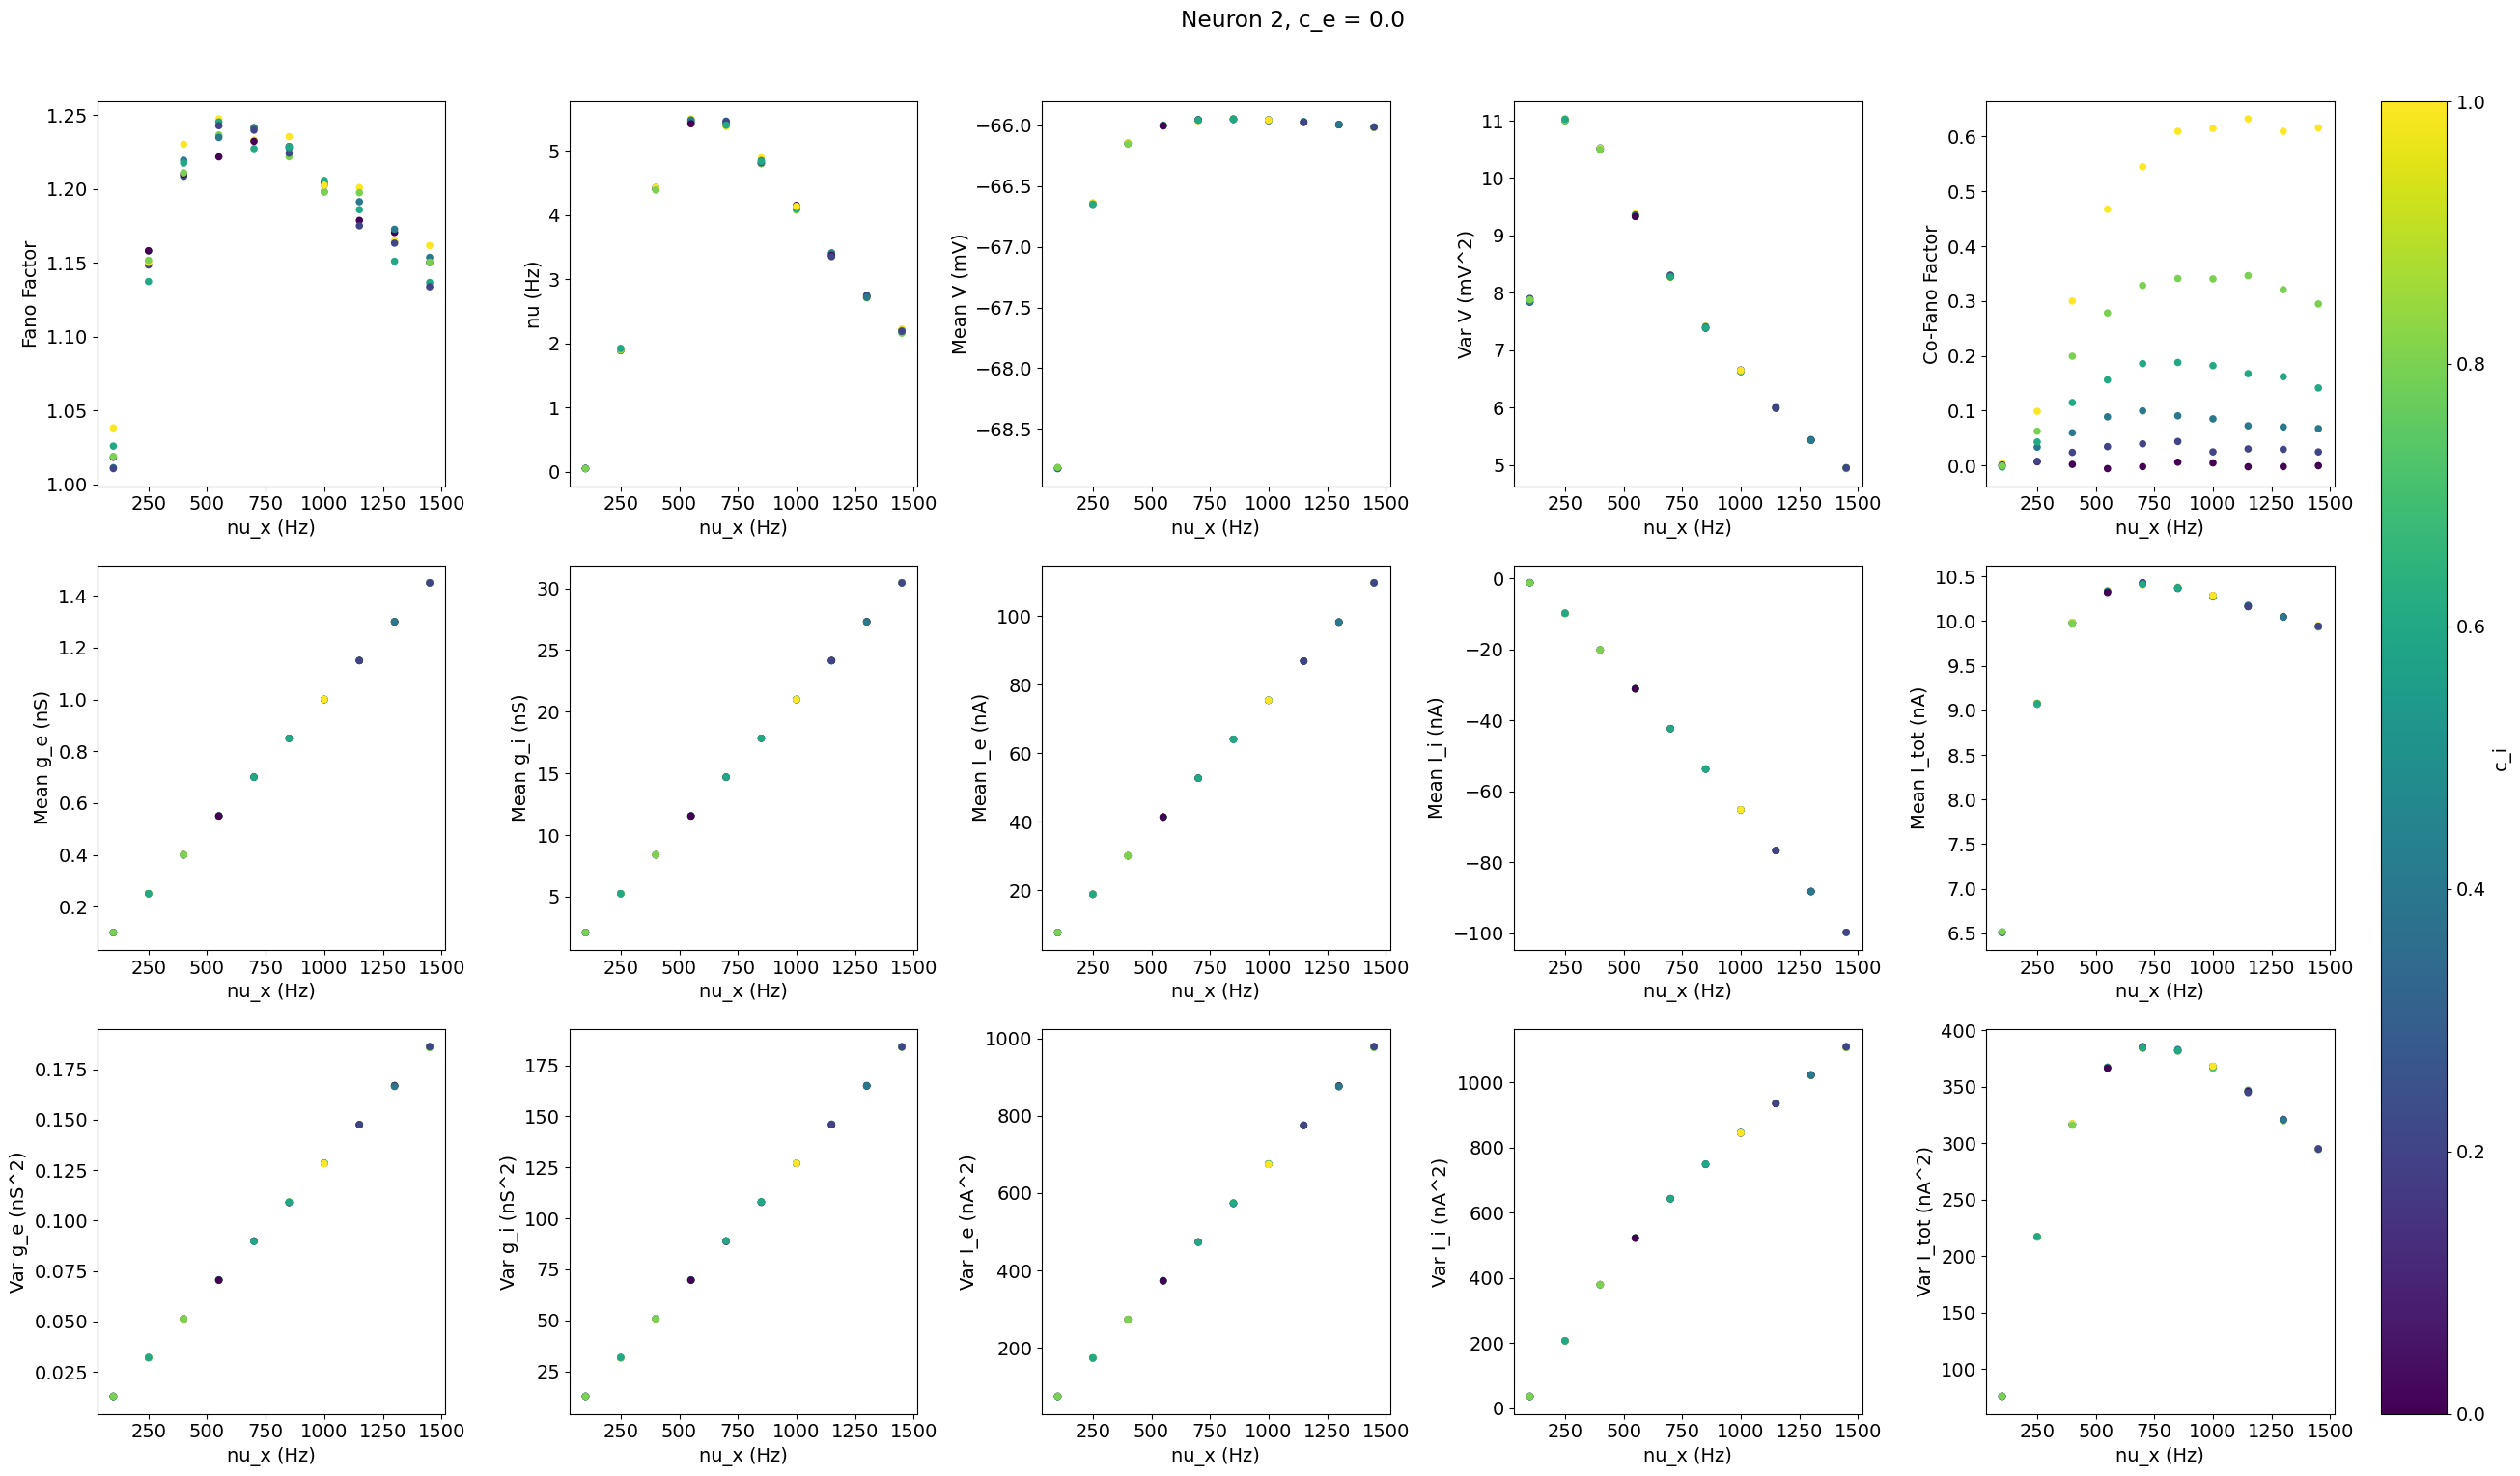

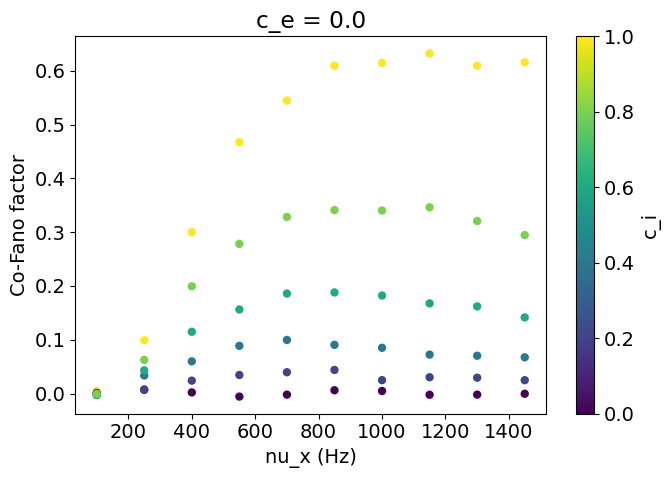

/var/folders/mb/f1_g1g0n1s13vfylsby2v1bm0000gn/T/ipykernel_88194/827275772.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])


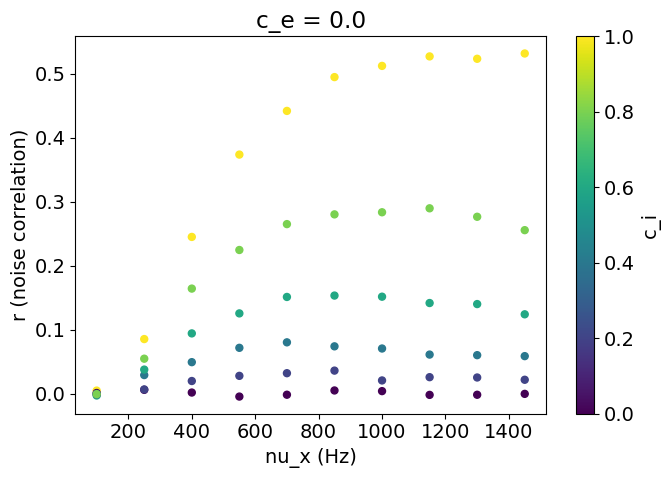

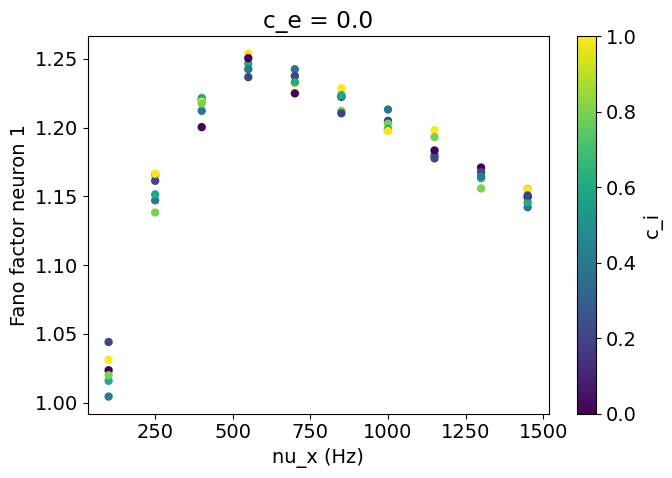

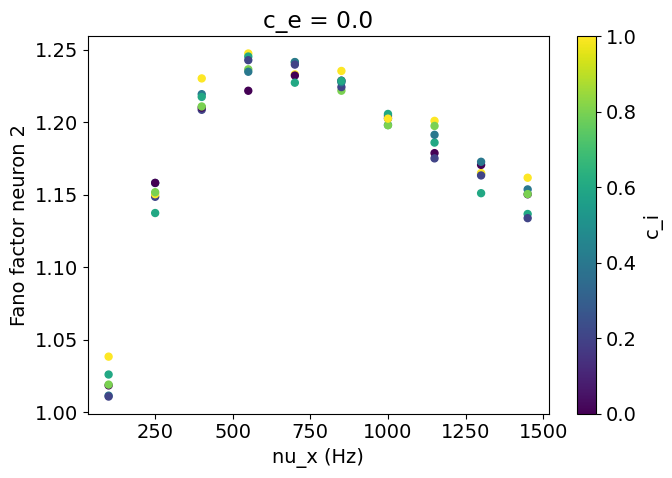

In [35]:
for ce_fixed in [0.0]:

    dfs = []
    for i in range(N_CELLS):
        df = dfs_all[i][dfs_all[i]["c_e"] == ce_fixed]
        dfs.append(df)
        
    df_co = df_co_all[df_co_all["c_e"] == ce_fixed]

    def plot_summary(df, neuron_idx, outname):
        fig, axs = plt.subplots(3, 5, figsize=(27, 15))
        fig.suptitle(f"Neuron {neuron_idx+1}, c_e = {ce_fixed}", y=1.02)
        opts = dict(c=df["c_i"], cmap="viridis", vmin=0, vmax=1, s=20)

        axs[0,0].scatter(df["nu_x"], df["fano_factor"], **opts); axs[0,0].set_xlabel("nu_x (Hz)"); axs[0,0].set_ylabel("Fano Factor")
        axs[0,1].scatter(df["nu_x"], df["nu"],          **opts); axs[0,1].set_xlabel("nu_x (Hz)"); axs[0,1].set_ylabel("nu (Hz)")
        axs[0,2].scatter(df["nu_x"], df["mean_V"],      **opts); axs[0,2].set_xlabel("nu_x (Hz)"); axs[0,2].set_ylabel("Mean V (mV)")
        axs[0,3].scatter(df["nu_x"], df["var_V"],       **opts); axs[0,3].set_xlabel("nu_x (Hz)"); axs[0,3].set_ylabel("Var V (mV^2)")
        axs[0,4].scatter(df["nu_x"], df_co["co_fano_factor"], **opts); axs[0,4].set_xlabel("nu_x (Hz)"); axs[0,4].set_ylabel("Co-Fano Factor")

        axs[1,0].scatter(df["nu_x"], df["mean_g_e"],    **opts); axs[1,0].set_xlabel("nu_x (Hz)"); axs[1,0].set_ylabel("Mean g_e (nS)")
        axs[1,1].scatter(df["nu_x"], df["mean_g_i"],    **opts); axs[1,1].set_xlabel("nu_x (Hz)"); axs[1,1].set_ylabel("Mean g_i (nS)")
        axs[1,2].scatter(df["nu_x"], df["mean_I_e"],    **opts); axs[1,2].set_xlabel("nu_x (Hz)"); axs[1,2].set_ylabel("Mean I_e (nA)")
        axs[1,3].scatter(df["nu_x"], df["mean_I_i"],    **opts); axs[1,3].set_xlabel("nu_x (Hz)"); axs[1,3].set_ylabel("Mean I_i (nA)")
        axs[1,4].scatter(df["nu_x"], df["mean_I_tot"],  **opts); axs[1,4].set_xlabel("nu_x (Hz)"); axs[1,4].set_ylabel("Mean I_tot (nA)")
        
        axs[2,0].scatter(df["nu_x"], df["var_g_e"],     **opts); axs[2,0].set_xlabel("nu_x (Hz)"); axs[2,0].set_ylabel("Var g_e (nS^2)")
        axs[2,1].scatter(df["nu_x"], df["var_g_i"],     **opts); axs[2,1].set_xlabel("nu_x (Hz)"); axs[2,1].set_ylabel("Var g_i (nS^2)")
        axs[2,2].scatter(df["nu_x"], df["var_I_e"],     **opts); axs[2,2].set_xlabel("nu_x (Hz)"); axs[2,2].set_ylabel("Var I_e (nA^2)")
        axs[2,3].scatter(df["nu_x"], df["var_I_i"],     **opts); axs[2,3].set_xlabel("nu_x (Hz)"); axs[2,3].set_ylabel("Var I_i (nA^2)")
        axs[2,4].scatter(df["nu_x"], df["var_I_tot"],   **opts); axs[2,4].set_xlabel("nu_x (Hz)"); axs[2,4].set_ylabel("Var I_tot (nA^2)")
        
        sm = plt.cm.ScalarMappable(cmap="viridis"); sm.set_clim(0,1)
        plt.tight_layout(rect=[0, 0, 0.96, 1])  # leave right margin
        fig.colorbar(sm, ax=axs.ravel().tolist(), location="right",
                    fraction=0.03, pad=0.02, label="c_i")
        plt.savefig(outname, dpi=300, bbox_inches="tight"); plt.show()
        
    for i, df in enumerate(dfs):
        plot_summary(df, i, f"detailed_summary_neuron{i+1}_by_c_i_fixed_c_e={ce_fixed}.png")
        
    plt.figure(figsize=(7,5))
    sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c_i"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
    plt.colorbar(sc, label="c_i")
    plt.title(f"c_e = {ce_fixed}")
    plt.tight_layout(); plt.savefig(f"co_fano_vs_nu_x_by_c_i_fixed_c_e={ce_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(7,5))
    df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
    sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c_i"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
    plt.colorbar(sc, label="c_i")
    plt.title(f"c_e = {ce_fixed}")
    plt.tight_layout(); plt.savefig(f"r_vs_nu_x_by_c_i_fixed_c_e={ce_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    # also plot the two fano factors in two separate plots versus nu_x
    plt.figure(figsize=(7,5))
    sc = plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], c=dfs[0]["c_i"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 1")
    plt.colorbar(sc, label="c_i")
    plt.title(f"c_e = {ce_fixed}")
    plt.tight_layout(); plt.savefig(f"fano1_vs_nu_x_by_c_i_fixed_c_e={ce_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(7,5))
    sc = plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], c=dfs[1]["c_i"], cmap="viridis", vmin=0, vmax=1, s=25)
    plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 2")
    plt.colorbar(sc, label="c_i")
    plt.title(f"c_e = {ce_fixed}")
    plt.tight_layout(); plt.savefig(f"fano2_vs_nu_x_by_c_i_fixed_c_e={ce_fixed}.png", dpi=300, bbox_inches="tight"); plt.show()

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trials = collect_data("../../outputs/conductance/double_lif/nu_x_c_e_c_i/20251016-110604-Ov4lxrFn")

In [41]:
# sort trials using params.get("nu_x")
trials.sort(key=lambda x: x[0].get("nu_x", 0))

[[1.         0.03512346]
 [0.03512346 1.        ]]
[[1.         0.48017881]
 [0.48017881 1.        ]]
[[1.         0.60014579]
 [0.60014579 1.        ]]
[[1.         0.68514826]
 [0.68514826 1.        ]]
[[1.         0.70978265]
 [0.70978265 1.        ]]
[[1.        0.7236313]
 [0.7236313 1.       ]]
[[1.         0.74209104]
 [0.74209104 1.        ]]
[[1.         0.74429324]
 [0.74429324 1.        ]]
[[1.         0.74926021]
 [0.74926021 1.        ]]
[[1.         0.74246873]
 [0.74246873 1.        ]]


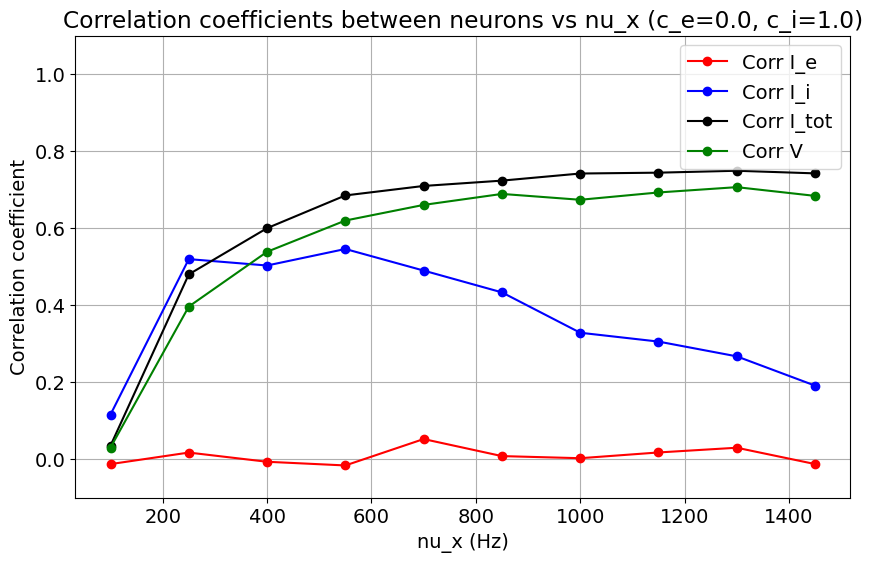

In [56]:
all_corr_I_e = []
all_corr_I_i = []
all_corr_I_tot = []
all_corr_V = []

c_e = 0.0
c_i = 1.0

for params, results in trials:
    if params.get("c_e") == c_e and params.get("c_i") == c_i:
        nu_x = params.get("nu_x")
        t = np.asarray(results["t"])
        I_tot = np.asarray(results["I_tot"])
        I_e = np.asarray(results["I_e"])
        I_i = np.asarray(results["I_i"])
        V = np.asarray(results["V"])
        
        # # for N_cells
        N_cells = params.get("N_cells", 1)
        # for i in range(N_cells):
            
        #     plt.figure()
        #     plt.plot(t, I_tot[i], label="I_tot", color="black", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_e[i], label="I_e", color="red", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_i[i], label="I_i", color="blue", alpha=0.7, linewidth=1)
        #     plt.title(f"Current traces for neuron {i+1}, nu_x={nu_x} Hz, c_e=0.0, c_i=1.0")
        #     # plot V too
        #     # plt.plot(t, V, label="V", color="green", alpha=0.7, linewidth=1)  # scale V for visibility
        #     plt.xlabel("Time (ms)")
        #     plt.ylabel("Current (nA)")
        #     plt.legend()
        #     # set xlim to show only last 10% of the time
        #     plt.xlim(t[-1] * 0.90, t[-1])
        #     # set ylim be fixed
        #     plt.ylim(-210, 210)
        #     plt.title(f"nu_x={nu_x} Hz")
        #     # set the plt size to be longer landscape
        #     plt.gcf().set_size_inches(15, 3)
        #     # plt.savefig(f"current_trace_nu_x_{nu_x}.png", dpi=300)
        #     plt.show()
            
        # compute the correlation between I_e an I_i between the two cells
        print(np.corrcoef(I_tot[0], I_tot[1]))
        
        corr_I_e = np.corrcoef(I_e[0], I_e[1])[0,1]
        corr_I_i = np.corrcoef(I_i[0], I_i[1])[0,1]
        corr_I_tot = np.corrcoef(I_tot[0], I_tot[1])[0,1]
        corr_V = np.corrcoef(V[0], V[1])[0,1]
        
        all_corr_I_e.append((nu_x, corr_I_e))
        all_corr_I_i.append((nu_x, corr_I_i))
        all_corr_I_tot.append((nu_x, corr_I_tot))
        all_corr_V.append((nu_x, corr_V))
        
# plot all correlations vs nu_x
all_corr_I_e = np.array(all_corr_I_e)
all_corr_I_i = np.array(all_corr_I_i)
all_corr_I_tot = np.array(all_corr_I_tot)
all_corr_V = np.array(all_corr_V)

plt.figure(figsize=(10,6))
plt.plot(all_corr_I_e[:,0], all_corr_I_e[:,1], marker='o', label="Corr I_e", color="red")
plt.plot(all_corr_I_i[:,0], all_corr_I_i[:,1], marker='o', label="Corr I_i", color="blue")
plt.plot(all_corr_I_tot[:,0], all_corr_I_tot[:,1], marker='o', label="Corr I_tot", color="black")
plt.plot(all_corr_V[:,0], all_corr_V[:,1], marker='o', label="Corr V", color="green")
plt.xlabel("nu_x (Hz)")
plt.ylabel("Correlation coefficient")
plt.title(f"Correlation coefficients between neurons vs nu_x (c_e={c_e}, c_i={c_i})")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()


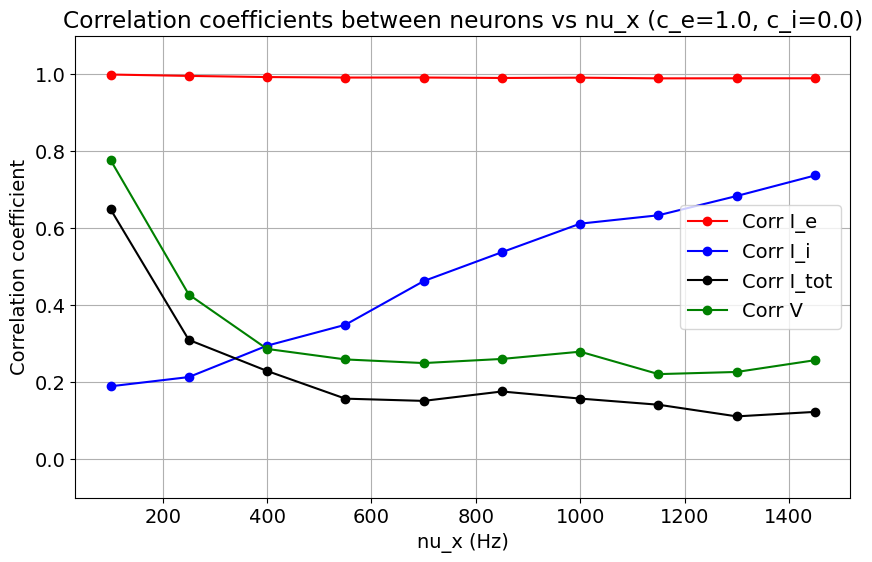

In [51]:
all_corr_I_e = []
all_corr_I_i = []
all_corr_I_tot = []
all_corr_V = []

c_e = 1.0
c_i = 0.0

for params, results in trials:
    if params.get("c_e") == c_e and params.get("c_i") == c_i:
        nu_x = params.get("nu_x")
        t = np.asarray(results["t"])
        I_tot = np.asarray(results["I_tot"])
        I_e = np.asarray(results["I_e"])
        I_i = np.asarray(results["I_i"])
        V = np.asarray(results["V"])
        
        # # for N_cells
        N_cells = params.get("N_cells", 1)
        # for i in range(N_cells):
            
        #     plt.figure()
        #     plt.plot(t, I_tot[i], label="I_tot", color="black", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_e[i], label="I_e", color="red", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_i[i], label="I_i", color="blue", alpha=0.7, linewidth=1)
        #     plt.title(f"Current traces for neuron {i+1}, nu_x={nu_x} Hz, c_e=0.0, c_i=1.0")
        #     # plot V too
        #     # plt.plot(t, V, label="V", color="green", alpha=0.7, linewidth=1)  # scale V for visibility
        #     plt.xlabel("Time (ms)")
        #     plt.ylabel("Current (nA)")
        #     plt.legend()
        #     # set xlim to show only last 10% of the time
        #     plt.xlim(t[-1] * 0.90, t[-1])
        #     # set ylim be fixed
        #     plt.ylim(-210, 210)
        #     plt.title(f"nu_x={nu_x} Hz")
        #     # set the plt size to be longer landscape
        #     plt.gcf().set_size_inches(15, 3)
        #     # plt.savefig(f"current_trace_nu_x_{nu_x}.png", dpi=300)
        #     plt.show()
            
        # compute the correlation between I_e an I_i between the two cells
        corr_I_e = np.corrcoef(I_e[0], I_e[1])[0,1]
        corr_I_i = np.corrcoef(I_i[0], I_i[1])[0,1]
        corr_I_tot = np.corrcoef(I_tot[0], I_tot[1])[0,1]
        corr_V = np.corrcoef(V[0], V[1])[0,1]
        
        all_corr_I_e.append((nu_x, corr_I_e))
        all_corr_I_i.append((nu_x, corr_I_i))
        all_corr_I_tot.append((nu_x, corr_I_tot))
        all_corr_V.append((nu_x, corr_V))
        
# plot all correlations vs nu_x
all_corr_I_e = np.array(all_corr_I_e)
all_corr_I_i = np.array(all_corr_I_i)
all_corr_I_tot = np.array(all_corr_I_tot)
all_corr_V = np.array(all_corr_V)

plt.figure(figsize=(10,6))
plt.plot(all_corr_I_e[:,0], all_corr_I_e[:,1], marker='o', label="Corr I_e", color="red")
plt.plot(all_corr_I_i[:,0], all_corr_I_i[:,1], marker='o', label="Corr I_i", color="blue")
plt.plot(all_corr_I_tot[:,0], all_corr_I_tot[:,1], marker='o', label="Corr I_tot", color="black")
plt.plot(all_corr_V[:,0], all_corr_V[:,1], marker='o', label="Corr V", color="green")
plt.xlabel("nu_x (Hz)")
plt.ylabel("Correlation coefficient")
plt.title(f"Correlation coefficients between neurons vs nu_x (c_e={c_e}, c_i={c_i})")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trials = collect_data("../../outputs/conductance/double_lif/nu_x_shared_i_and_e/20251016-150037-mgcbtg57")
trials.sort(key=lambda x: x[0].get("nu_x", 0))

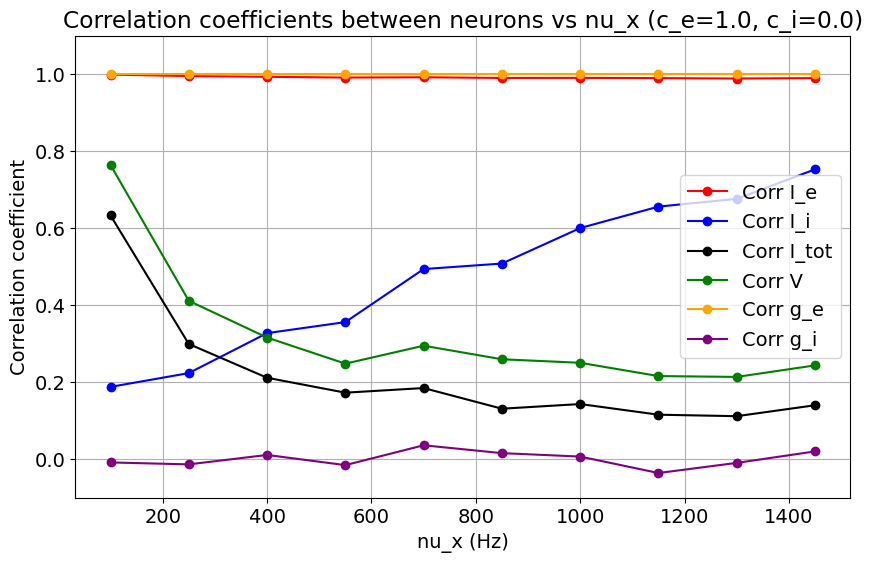

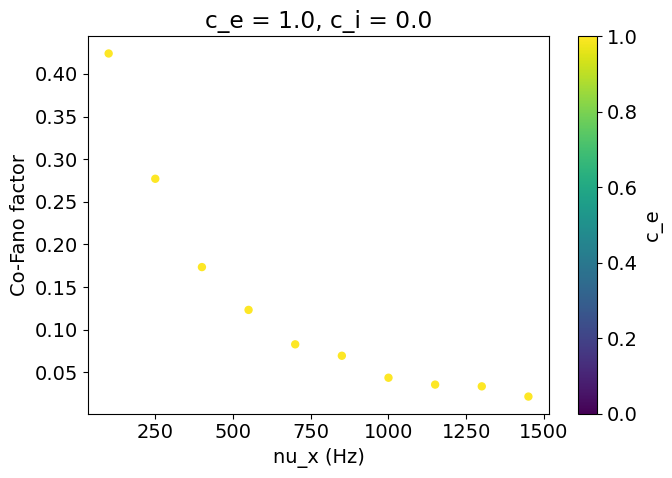

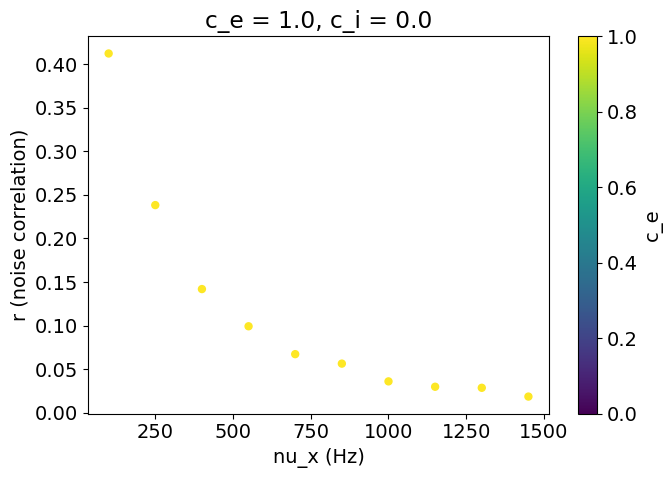

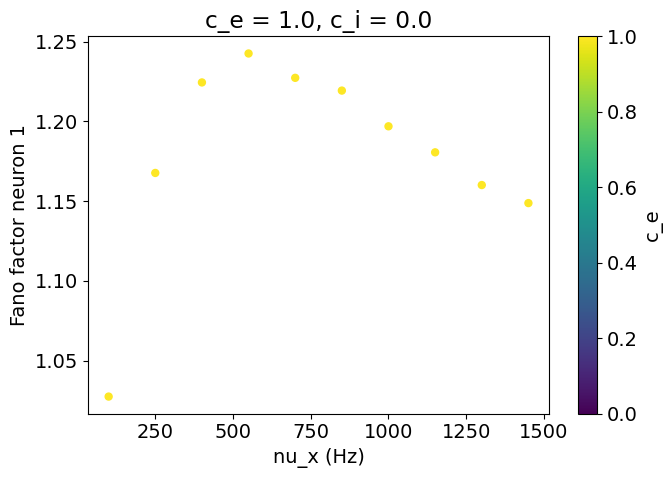

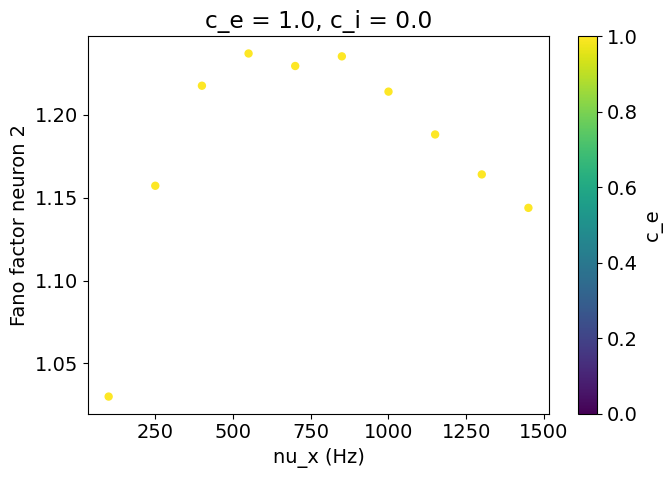

In [66]:
all_corr_I_e = []
all_corr_I_i = []
all_corr_I_tot = []
all_corr_V = []
all_corr_g_e = []
all_corr_g_i = []

c_e = 1.0
c_i = 0.0

for params, results in trials:
    if params.get("c_e") == c_e and params.get("c_i") == c_i:
        nu_x = params.get("nu_x")
        t = np.asarray(results["t"])
        I_tot = np.asarray(results["I_tot"])
        I_e = np.asarray(results["I_e"])
        I_i = np.asarray(results["I_i"])
        V = np.asarray(results["V"])
        g_e = np.asarray(results["g_e"])
        g_i = np.asarray(results["g_i"])
        
        # # for N_cells
        N_cells = params.get("N_cells", 1)
        # for i in range(N_cells):
            
        #     plt.figure()
        #     plt.plot(t, I_tot[i], label="I_tot", color="black", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_e[i], label="I_e", color="red", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_i[i], label="I_i", color="blue", alpha=0.7, linewidth=1)
        #     plt.title(f"Current traces for neuron {i+1}, nu_x={nu_x} Hz, c_e=0.0, c_i=1.0")
        #     # plot V too
        #     # plt.plot(t, V, label="V", color="green", alpha=0.7, linewidth=1)  # scale V for visibility
        #     plt.xlabel("Time (ms)")
        #     plt.ylabel("Current (nA)")
        #     plt.legend()
        #     # set xlim to show only last 10% of the time
        #     plt.xlim(t[-1] * 0.90, t[-1])
        #     # set ylim be fixed
        #     plt.ylim(-210, 210)
        #     plt.title(f"nu_x={nu_x} Hz")
        #     # set the plt size to be longer landscape
        #     plt.gcf().set_size_inches(15, 3)
        #     # plt.savefig(f"current_trace_nu_x_{nu_x}.png", dpi=300)
        #     plt.show()
            
        # compute the correlation between I_e an I_i between the two cells
        corr_I_e = np.corrcoef(I_e[0], I_e[1])[0,1]
        corr_I_i = np.corrcoef(I_i[0], I_i[1])[0,1]
        corr_I_tot = np.corrcoef(I_tot[0], I_tot[1])[0,1]
        corr_V = np.corrcoef(V[0], V[1])[0,1]
        corr_g_e = np.corrcoef(g_e[0], g_e[1])[0,1]
        corr_g_i = np.corrcoef(g_i[0], g_i[1])[0,1]
        
        all_corr_I_e.append((nu_x, corr_I_e))
        all_corr_I_i.append((nu_x, corr_I_i))
        all_corr_I_tot.append((nu_x, corr_I_tot))
        all_corr_V.append((nu_x, corr_V))
        all_corr_g_e.append((nu_x, corr_g_e))
        all_corr_g_i.append((nu_x, corr_g_i))
        
# plot all correlations vs nu_x
all_corr_I_e = np.array(all_corr_I_e)
all_corr_I_i = np.array(all_corr_I_i)
all_corr_I_tot = np.array(all_corr_I_tot)
all_corr_V = np.array(all_corr_V)
all_corr_g_e = np.array(all_corr_g_e)
all_corr_g_i = np.array(all_corr_g_i)

plt.figure(figsize=(10,6))
plt.plot(all_corr_I_e[:,0], all_corr_I_e[:,1], marker='o', label="Corr I_e", color="red")
plt.plot(all_corr_I_i[:,0], all_corr_I_i[:,1], marker='o', label="Corr I_i", color="blue")
plt.plot(all_corr_I_tot[:,0], all_corr_I_tot[:,1], marker='o', label="Corr I_tot", color="black")
plt.plot(all_corr_V[:,0], all_corr_V[:,1], marker='o', label="Corr V", color="green")
plt.plot(all_corr_g_e[:,0], all_corr_g_e[:,1], marker='o', label="Corr g_e", color="orange")
plt.plot(all_corr_g_i[:,0], all_corr_g_i[:,1], marker='o', label="Corr g_i", color="purple")
plt.xlabel("nu_x (Hz)")
plt.ylabel("Correlation coefficient")
plt.title(f"Correlation coefficients between neurons vs nu_x (c_e={c_e}, c_i={c_i})")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.savefig(f"correlation_coefficients_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight")
plt.show()

# plot the co-fano factor, fano 1, fano 2, and r versus nu_x for this dataset, no need for other values of c_e and c_i since they are fixed here
# no need for mean V and var V etc.

dfs = []
for i in range(2):
    rows = []
    for params, results in trials:
        if params.get("c_e") == c_e and params.get("c_i") == c_i:
            row = {"nu_x": float(params["nu_x"]),
                   "c_e": float(params["c_e"]),
                   "c_i": float(params["c_i"])}
            for k in keys:
                v = results[k]
                if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                    row[k] = float(v)
                elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == 2:
                    row[k] = float(v[i])
            rows.append(row)
    dfs.append(pd.DataFrame(rows))
df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "c_e":  [float(p["c_e"])   for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "c_i":  [float(p["c_i"])   for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for p, r in trials if p.get("c_e") == c_e and p.get("c_i") == c_i]
    }
)
plt.rcParams.update({'font.size': 14})

# plot co-fano factor versus nu_x, color by c (which is fixed here)
plt.figure(figsize=(7,5))
sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"co_fano_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"r_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], c=dfs[0]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 1")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"fano1_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], c=dfs[1]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 2")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"fano2_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

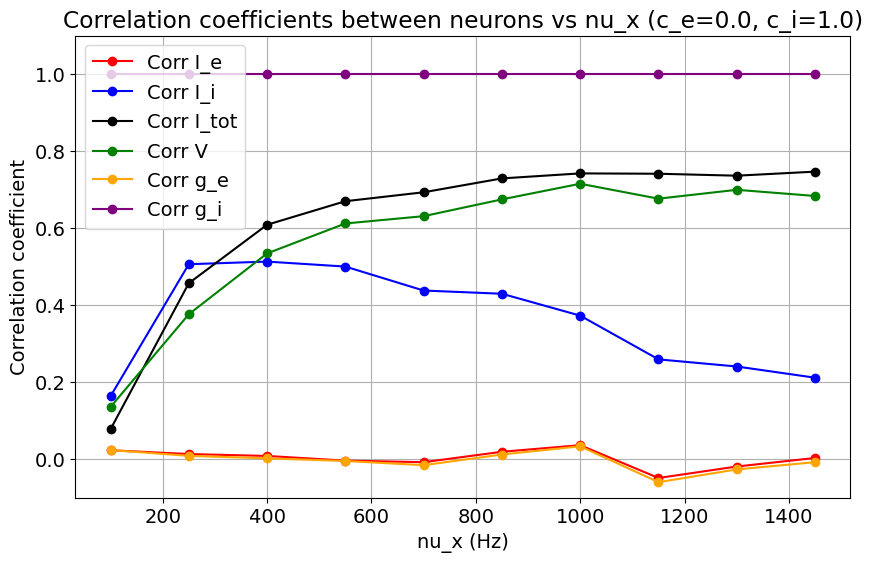

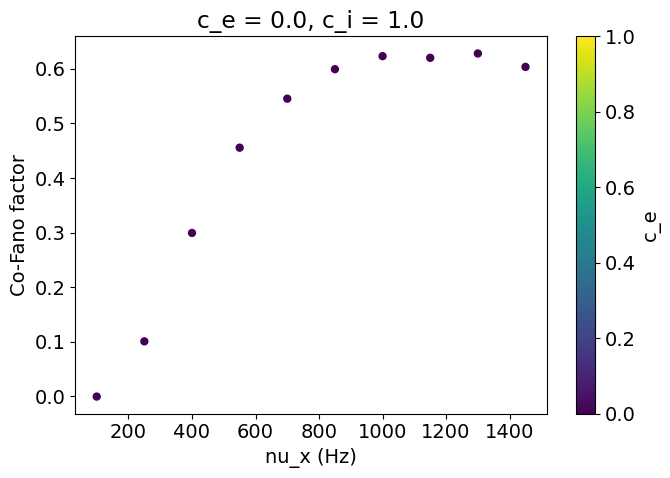

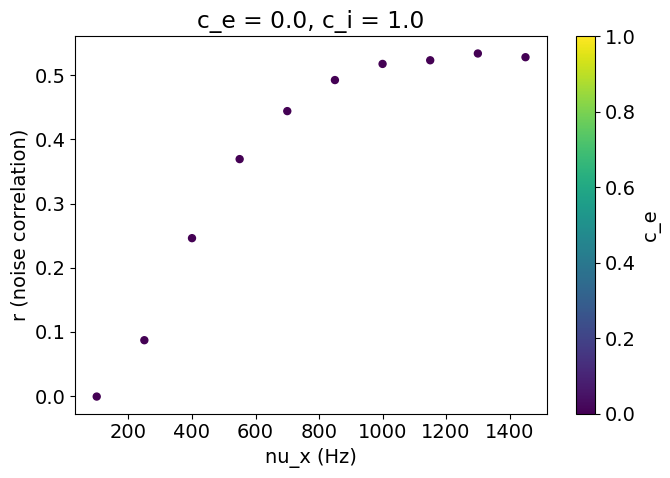

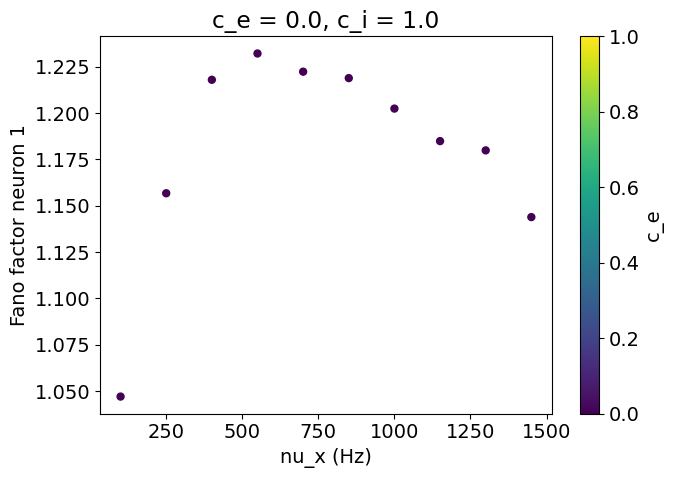

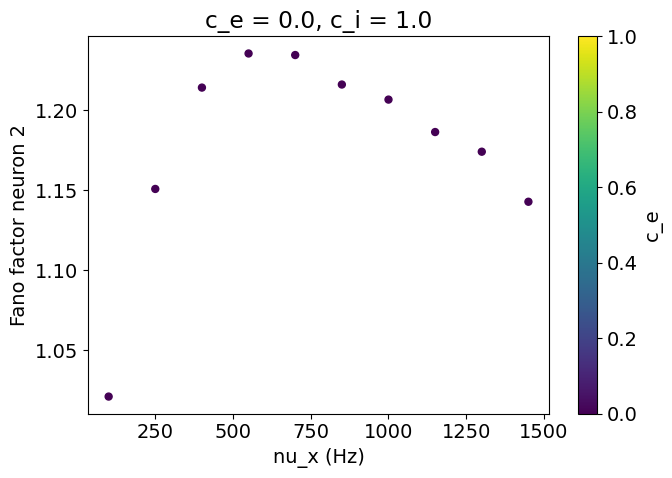

In [67]:
all_corr_I_e = []
all_corr_I_i = []
all_corr_I_tot = []
all_corr_V = []
all_corr_g_e = []
all_corr_g_i = []

c_e = 0.0
c_i = 1.0

for params, results in trials:
    if params.get("c_e") == c_e and params.get("c_i") == c_i:
        nu_x = params.get("nu_x")
        t = np.asarray(results["t"])
        I_tot = np.asarray(results["I_tot"])
        I_e = np.asarray(results["I_e"])
        I_i = np.asarray(results["I_i"])
        V = np.asarray(results["V"])
        g_e = np.asarray(results["g_e"])
        g_i = np.asarray(results["g_i"])
        
        # # for N_cells
        N_cells = params.get("N_cells", 1)
        # for i in range(N_cells):
            
        #     plt.figure()
        #     plt.plot(t, I_tot[i], label="I_tot", color="black", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_e[i], label="I_e", color="red", alpha=0.7, linewidth=1)
        #     plt.plot(t, I_i[i], label="I_i", color="blue", alpha=0.7, linewidth=1)
        #     plt.title(f"Current traces for neuron {i+1}, nu_x={nu_x} Hz, c_e=0.0, c_i=1.0")
        #     # plot V too
        #     # plt.plot(t, V, label="V", color="green", alpha=0.7, linewidth=1)  # scale V for visibility
        #     plt.xlabel("Time (ms)")
        #     plt.ylabel("Current (nA)")
        #     plt.legend()
        #     # set xlim to show only last 10% of the time
        #     plt.xlim(t[-1] * 0.90, t[-1])
        #     # set ylim be fixed
        #     plt.ylim(-210, 210)
        #     plt.title(f"nu_x={nu_x} Hz")
        #     # set the plt size to be longer landscape
        #     plt.gcf().set_size_inches(15, 3)
        #     # plt.savefig(f"current_trace_nu_x_{nu_x}.png", dpi=300)
        #     plt.show()
            
        # compute the correlation between I_e an I_i between the two cells
        corr_I_e = np.corrcoef(I_e[0], I_e[1])[0,1]
        corr_I_i = np.corrcoef(I_i[0], I_i[1])[0,1]
        corr_I_tot = np.corrcoef(I_tot[0], I_tot[1])[0,1]
        corr_V = np.corrcoef(V[0], V[1])[0,1]
        corr_g_e = np.corrcoef(g_e[0], g_e[1])[0,1]
        corr_g_i = np.corrcoef(g_i[0], g_i[1])[0,1]
        
        all_corr_I_e.append((nu_x, corr_I_e))
        all_corr_I_i.append((nu_x, corr_I_i))
        all_corr_I_tot.append((nu_x, corr_I_tot))
        all_corr_V.append((nu_x, corr_V))
        all_corr_g_e.append((nu_x, corr_g_e))
        all_corr_g_i.append((nu_x, corr_g_i))
        
# plot all correlations vs nu_x
all_corr_I_e = np.array(all_corr_I_e)
all_corr_I_i = np.array(all_corr_I_i)
all_corr_I_tot = np.array(all_corr_I_tot)
all_corr_V = np.array(all_corr_V)
all_corr_g_e = np.array(all_corr_g_e)
all_corr_g_i = np.array(all_corr_g_i)

plt.figure(figsize=(10,6))
plt.plot(all_corr_I_e[:,0], all_corr_I_e[:,1], marker='o', label="Corr I_e", color="red")
plt.plot(all_corr_I_i[:,0], all_corr_I_i[:,1], marker='o', label="Corr I_i", color="blue")
plt.plot(all_corr_I_tot[:,0], all_corr_I_tot[:,1], marker='o', label="Corr I_tot", color="black")
plt.plot(all_corr_V[:,0], all_corr_V[:,1], marker='o', label="Corr V", color="green")
plt.plot(all_corr_g_e[:,0], all_corr_g_e[:,1], marker='o', label="Corr g_e", color="orange")
plt.plot(all_corr_g_i[:,0], all_corr_g_i[:,1], marker='o', label="Corr g_i", color="purple")
plt.xlabel("nu_x (Hz)")
plt.ylabel("Correlation coefficient")
plt.title(f"Correlation coefficients between neurons vs nu_x (c_e={c_e}, c_i={c_i})")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.savefig(f"correlation_coefficients_shared_input_ce={c_e}_ci={c_i}.png", dpi=300, bbox_inches="tight")
plt.show()


# plot the co-fano factor, fano 1, fano 2, and r versus nu_x for this dataset, no need for other values of c_e and c_i since they are fixed here
# no need for mean V and var V etc.

dfs = []
for i in range(2):
    rows = []
    for params, results in trials:
        if params.get("c_e") == c_e and params.get("c_i") == c_i:
            row = {"nu_x": float(params["nu_x"]),
                   "c_e": float(params["c_e"]),
                   "c_i": float(params["c_i"])}
            for k in keys:
                v = results[k]
                if np.isscalar(v) or (isinstance(v, np.ndarray) and v.ndim == 0):
                    row[k] = float(v)
                elif isinstance(v, np.ndarray) and v.ndim == 1 and v.size == 2:
                    row[k] = float(v[i])
            rows.append(row)
    dfs.append(pd.DataFrame(rows))
df_co = pd.DataFrame(
    {"nu_x": [float(p["nu_x"]) for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "c_e":  [float(p["c_e"])   for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "c_i":  [float(p["c_i"])   for p, _ in trials if p.get("c_e") == c_e and p.get("c_i") == c_i],
     "co_fano_factor": [float(np.ravel(r["co_fano_factor"])[0]) for p, r in trials if p.get("c_e") == c_e and p.get("c_i") == c_i]
    }
)
plt.rcParams.update({'font.size': 14})

# plot co-fano factor versus nu_x, color by c (which is fixed here)
plt.figure(figsize=(7,5))
sc = plt.scatter(df_co["nu_x"], df_co["co_fano_factor"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Co-Fano factor")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"co_fano_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
df_co["r"] = df_co["co_fano_factor"] / np.sqrt(dfs[0]["fano_factor"] * dfs[1]["fano_factor"])
sc = plt.scatter(df_co["nu_x"], df_co["r"], c=df_co["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("r (noise correlation)")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"r_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[0]["nu_x"], dfs[0]["fano_factor"], c=dfs[0]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 1")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"fano1_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
sc = plt.scatter(dfs[1]["nu_x"], dfs[1]["fano_factor"], c=dfs[1]["c_e"], cmap="viridis", vmin=0, vmax=1, s=25)
plt.xlabel("nu_x (Hz)"); plt.ylabel("Fano factor neuron 2")
plt.colorbar(sc, label="c_e")  # or c_i, they are fixed
plt.title(f"c_e = {c_e}, c_i = {c_i}")
plt.tight_layout(); plt.savefig(f"fano2_vs_nu_x_c_e={c_e}_c_i={c_i}.png", dpi=300, bbox_inches="tight"); plt.show()


Now I have some result, but it's quite mysterious.

We are scanning nu_x from 100 to 1500 Hz.

When c_e = 1, c_i = 0, only E is shared. Both FF1 and FF2 is the same as nu_x turns up, which is good truth check. However, at low nu_x, say nu_x = 100, coFF is r is quite high around 0.5, which is expected. But when nu_x is high, say nu_x = 1500, coFF and r both goes and asymptotes to near zero. 

On contrary, when c_e = 0, c_i = 1, only I is shared. The trend is reversed. At low nu_x, coFF and r is near zero; At high nu_x, coFF and r goes up and asymptotes to around 0.5. 

This is kind of mysterious. How can we interpret? Intuitively, we would think for different values of nu_x, coFF and r should stays around the same. However, they seem to be nu_x dependent. 

In fact, if we check the corrcoeff between the E, I and total currents, we see that in the E sharing scenario, corr_Ie stays high at 1, regardless of nu_x. However, we see corr_Ii increasing as nu_x goes up! Note that we kept c_i fixed at 0 in this scenario. No I is shared, but corr_Ii goes up. For corr_Itot, it starts high at 0.8, but asymptotes to 0.2 as nu_x goes up. 

In the I sharing case, corrIe stays low at 0, regardless of nu_x, expected. But corr_Ii also stays low at beginning, around 0.2, it goes up to 0.5 around nu_x = 400, plataeued, then drops back to 0.2 as nu_x goes up. The corr_Itot starts similarly at 0.2 and asymptotes around 0.8. 

How to think about this phenomenon?